# Neural Machine Translation

Description of the dataset

In [1]:
%matplotlib inline
from tqdm import tqdm_notebook as tqdm

# Basic Packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import torchtext
from torchtext.datasets import TranslationDataset, WMT14
from torchtext.data import Field, BucketIterator

import spacy

import random
import math
import os

import itertools
import allennlp

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re

In [2]:
from allennlp.modules.attention import LinearAttention, CosineAttention, BilinearAttention, DotProductAttention

# Global Parameters

In [3]:
SEED = 1
BATCH_SIZE = 512
N_EPOCHS = 100
CLIP = 10
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
ENC_HID_DIM = 512
DEC_HID_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

SAVE_DIR = 'exp_small_data_100'

random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
spacy_fr = spacy.load('fr')
spacy_en = spacy.load('en')

In [5]:
# This tokenizer when creating the initial data splits filtering
def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings
    """
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [6]:
SRC = Field(tokenize=tokenize_en, init_token='<sos>', eos_token='<eos>', lower=True)
TRG = Field(tokenize=tokenize_fr, init_token='<sos>', eos_token='<eos>', lower=True)

# 1. Exploratory Data Analysis

## 1.1 Loading and Preprocessing

In this example, spacy pretrained tokenizers are used to load the English and German datasets.
These spacy models can be used in conjunction with torchtext, allowing the processed data to populate torch tensors and dataset iterators to be created for training. 

### Filter data to smaller dataset

In [23]:
class FrenchTatoeba(TranslationDataset):
    """English-to-French dataset from Tatoeba"""

    urls = ['https://download.pytorch.org/tutorial/data.zip']
    name = 'FrenchTatoeba'
    dirname = ''
    
    @classmethod
    def format_data(cls, download_dir, lang1, lang2, reverse=False):
        random.seed(1) # Get same split every time
        print("Reading lines...")

        # Read the file and split into lines
        lines = open(os.path.join(download_dir,'data/%s-%s.txt' % (lang1, lang2)), encoding='utf-8').read().strip().split('\n')

        # Split every line into pairs and normalize
        pairs = [[s for s in l.split('\t')] for l in lines]

        # Reverse pairs
        if reverse:
            pairs = [list(reversed(p)) for p in pairs]
             
        with open(os.path.join(download_dir,'all_data.en'), 'w') as lang1_file, \
                open(os.path.join(download_dir,'all_data.fr'), 'w') as lang2_file:
            for p in pairs:
                lang1_file.write(p[0] + '\n')
                lang2_file.write(p[1] + '\n')

    @classmethod
    def all_data(cls, exts, fields, root='.data',
               train='all_data', validation=None, test=None, **kwargs):
        """Create dataset objects for splits of the Tatoeba dataset.
        Arguments:
            exts: A tuple containing the extension to path for each language.
            fields: A tuple containing the fields that will be used for data
                in each language.
            root: Root dataset storage directory. Default is '.data'.
            train: The prefix of the train data. Default: 'train'.
        """
        
        if 'path' not in kwargs:
            expected_folder = os.path.join(root, cls.name)
            path = expected_folder if os.path.exists(expected_folder) else None
        else:
            path = kwargs['path']
            del kwargs['path']
        
        if path is None:
            path = cls.download(root)
        
        cls.format_data(path, 'eng', 'fra')

        train_data = None if train is None else cls(
            os.path.join(path, train), exts, fields, **kwargs)
        val_data = None if validation is None else cls(
            os.path.join(path, validation), exts, fields, **kwargs)
        test_data = None if test is None else cls(
            os.path.join(path, test), exts, fields, **kwargs)
        
        return tuple(d for d in (train_data, val_data, test_data)
                     if d is not None)
    
    @classmethod
    def splits(cls, exts, fields, root='.data',
               train='train', validation='val', test='test', **kwargs):
        """Create dataset objects for splits of the Multi30k dataset.
        Arguments:
            exts: A tuple containing the extension to path for each language.
            fields: A tuple containing the fields that will be used for data
                in each language.
            root: Root dataset storage directory. Default is '.data'.
            train: The prefix of the train data. Default: 'train'.
            validation: The prefix of the validation data. Default: 'val'.
            test: The prefix of the test data. Default: 'test'.
            Remaining keyword arguments: Passed to the splits method of
                Dataset.
        """
        
        if 'path' not in kwargs:
            expected_folder = os.path.join(root, cls.name)
            path = expected_folder if os.path.exists(expected_folder) else None
        else:
            path = kwargs['path']
            del kwargs['path']
            
        return super(FrenchTatoeba, cls).splits(
            exts, fields, path, root, train, validation, test, **kwargs)

In [8]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
#     s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def tokenize_fr(text):
    """
    Tokenizes French text from a string into a list of strings
    """
    text = normalizeString(text)
    return [tok.text for tok in spacy_fr.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    text = normalizeString(text)
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [9]:
MAX_LENGTH = 20

def filterPair(p):
    return len(p[0]) < MAX_LENGTH and \
        len(p[1]) < MAX_LENGTH

In [72]:
all_data = FrenchTatoeba.all_data(exts=('.en', '.fr'), 
                  fields=(SRC, TRG), 
                  filter_pred=lambda ex: filterPair([ex.src, ex.trg]))[0]

Reading lines...


In [73]:
for e in all_data[:10]:
    print(e.src, e.trg)

['go', '.'] ['va', '!']
['run', '!'] ['cours', '!']
['run', '!'] ['courez', '!']
['wow', '!'] ['ca', 'alors', '!']
['fire', '!'] ['au', 'feu', '!']
['help', '!'] ['a', 'l', 'aide', '!']
['jump', '.'] ['saute', '.']
['stop', '!'] ['ca', 'suffit', '!']
['stop', '!'] ['stop', '!']
['stop', '!'] ['arrete', 'toi', '!']


In [88]:
download_dir = os.path.join('.data', FrenchTatoeba.name)
n_examples = len(all_data)
idx_array = list(range(n_examples))
random.shuffle(idx_array)
train_indexs = idx_array[:int(0.8*n_examples)] # 80% training data
val_indexs = idx_array[int(0.8*n_examples):int(0.9*n_examples)]
test_indexs = idx_array[int(0.9*n_examples):]

### Save train, test, val files for furture experiments 

In [ ]:
with open(os.path.join(download_dir,'train.en'), 'w') as lang1_file, \
        open(os.path.join(download_dir,'train.fr'), 'w') as lang2_file:
    for i in train_indexs:
        lang1_file.write(' '.join(all_data[i].src) + '\n')
        lang2_file.write(' '.join(all_data[i].trg) + '\n')

with open(os.path.join(download_dir,'val.en'), 'w') as lang1_file, \
        open(os.path.join(download_dir,'val.fr'), 'w') as lang2_file:
    for i in val_indexs:
        lang1_file.write(' '.join(all_data[i].src) + '\n')
        lang2_file.write(' '.join(all_data[i].trg) + '\n')

with open(os.path.join(download_dir,'test.en'), 'w') as lang1_file, \
        open(os.path.join(download_dir,'test.fr'), 'w') as lang2_file:
    for i in test_indexs:
        lang1_file.write(' '.join(all_data[i].src) + '\n')
        lang2_file.write(' '.join(all_data[i].trg) + '\n')


### Load individual datasets

In [8]:
train_data, valid_data, test_data = FrenchTatoeba.splits(path='./.data/FrenchTatoeba/', exts=('.en', '.fr'), fields=(SRC, TRG))

In [9]:
SRC.build_vocab(train_data, min_freq=5)
TRG.build_vocab(train_data, min_freq=5)

In [10]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)

In [11]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), batch_size=BATCH_SIZE, device=device)

## 1.2 Target distribution analysis

In [12]:
print('Training set size: ', len(train_data))
print('Validation set size: ', len(valid_data))
print('Testing set size: ', len(test_data))

print('Size of English vocabulary: ', len(SRC.vocab))
print('Size of French vocabulary: ', len(TRG.vocab))

Training set size:  107885
Validation set size:  13486
Testing set size:  13486
Size of English vocabulary:  4791
Size of French vocabulary:  6734


In [13]:
def show_dual_hist(data, data_src_title, data_tgt_title, title):
    data_1 = np.asarray([len(x.src) for x in data])
    data_2 = np.asarray([len(x.trg) for x in data])
    max_len = max(max(data_1),max(data_2))
    bins = range(1, max_len + 1, 1)
    plt.hist([data_1, data_2], bins, label=[data_src_title, data_tgt_title], align='left')
    plt.legend(loc='upper right')

    plt.grid(True)
    plt.xticks(range(1, max_len))
    plt.title(title)
    plt.ylabel("Number of examples")
    plt.xlabel("Example label")
    plt.figure(figsize=(180, 16), dpi= 80, facecolor='w', edgecolor='k')
    plt.show()

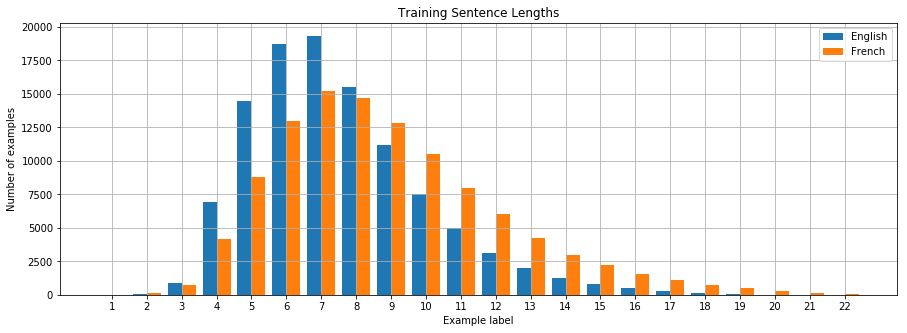

<Figure size 14400x1280 with 0 Axes>

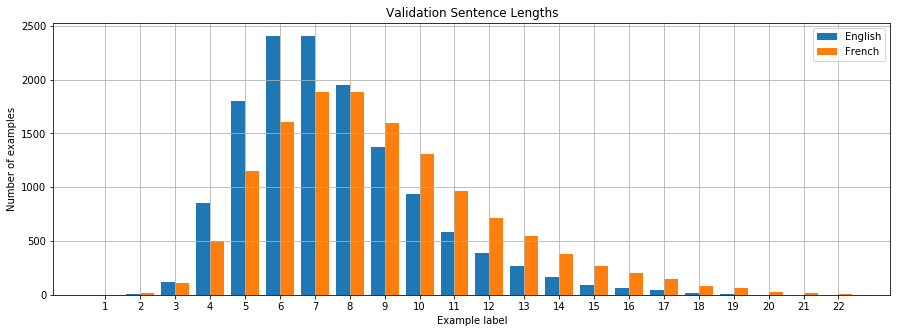

<Figure size 14400x1280 with 0 Axes>

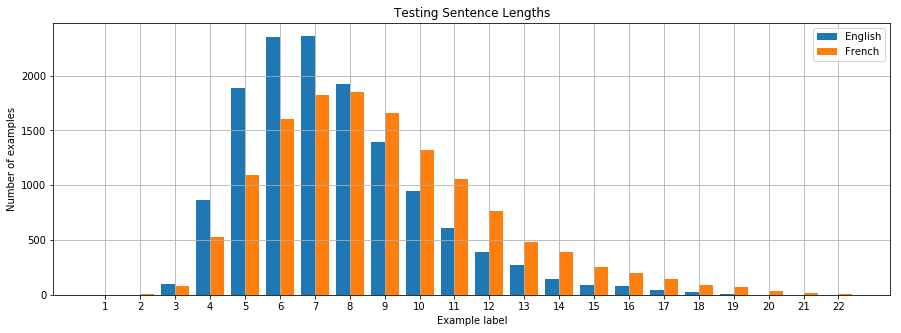

<Figure size 14400x1280 with 0 Axes>

In [14]:
plt.rcParams['figure.figsize'] = [15, 5]
show_dual_hist(train_data,
               'English', 
               'French', 
               "Training Sentence Lengths")
show_dual_hist(valid_data,
               'English', 
               'French', 
               "Validation Sentence Lengths")
show_dual_hist(test_data,
               'English', 
               'French', 
               "Testing Sentence Lengths")

In [15]:
def word_frequency_bar_plot(data, data_title, top_n=100):
    objects = sorted(data.freqs, key=data.freqs.get, reverse=True)[0:top_n]
    counts = [data.freqs[o] for o in objects]
    y_pos = np.arange(len(objects))

    plt.barh(y_pos, counts, align='center', alpha=0.5)
    plt.yticks(y_pos, objects)
    plt.gca().invert_yaxis()
    plt.xlabel('Count')
    plt.title(data_title + " Top " + str(top_n) + " word counts")
    plt.show()

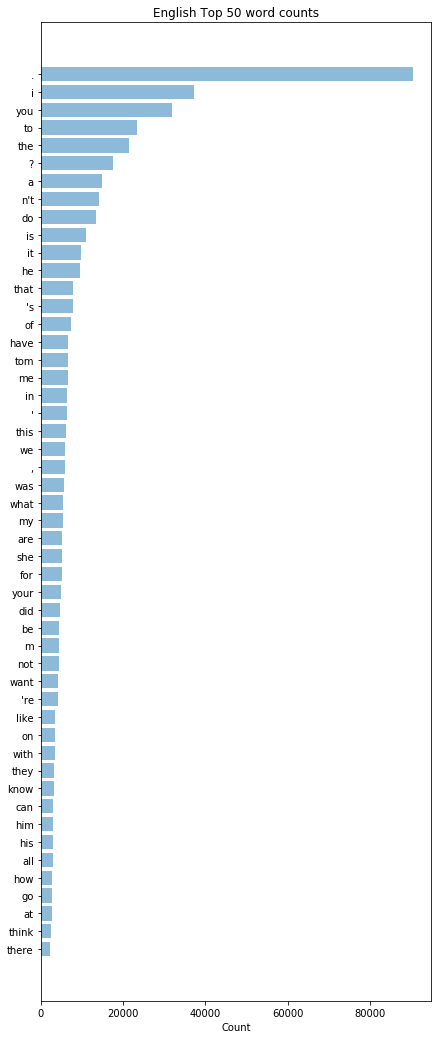

In [16]:
plt.rcParams['figure.figsize'] = [7, 18]
word_frequency_bar_plot(SRC.vocab, 'English', top_n=50)

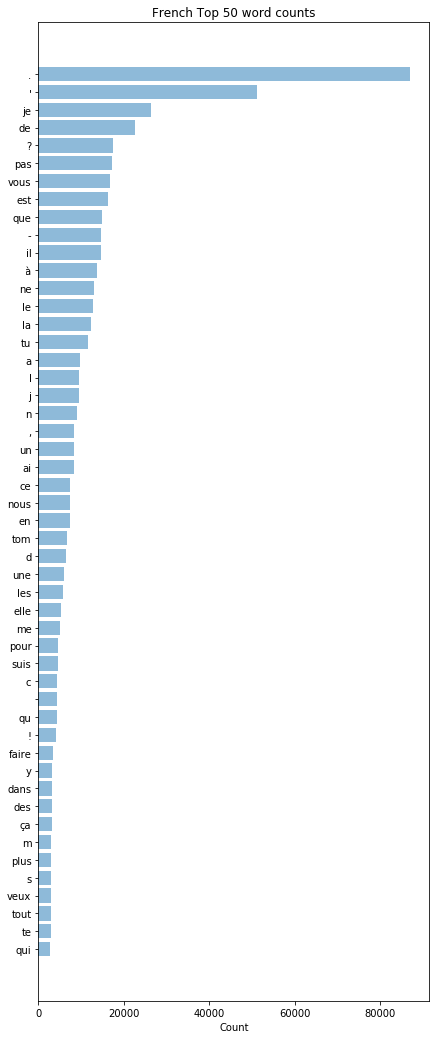

In [17]:
plt.rcParams['figure.figsize'] = [7, 18]
word_frequency_bar_plot(TRG.vocab, 'French', top_n=50)

# 2. Model Building

## 2.1 Utilities for training and testing

In [18]:
# Allows us to optimize the encoder and decoder separately
class MultipleOptimizer(object):
    def __init__(self, *op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [19]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    with tqdm(total=len(iterator)) as t:
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            optimizer.zero_grad()

            output = model(src, trg)
            loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))
            loss.backward()

            if clip: 
                torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

            optimizer.step()
            epoch_loss += loss.item()
            
            t.set_postfix(loss='{:05.3f}'.format(epoch_loss / len(iterator)))
            t.update()
        
    return epoch_loss / len(iterator)

In [20]:
def evaluate(model, iterator, criterion):
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):
            src = batch.src
            trg = batch.trg

            output = model(src, trg, 0) #turn off teacher forcing
            loss = criterion(output[1:].view(-1, output.shape[2]), trg[1:].view(-1))
            epoch_loss += loss.item()
            
    return epoch_loss / len(iterator)

In [21]:
def eval_metric(history, metric_name):
  
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_EPOCHS+1)

    plt.plot(e, metric, color='navy', label='Train ' + metric_name)
    plt.plot(e, val_metric, color='red', label='Validation ' + metric_name)
    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.legend()
    plt.show()

In [22]:
def plot_metrics(metrics_dict, title, chart_filter=''):
    data = pd.DataFrame.from_dict(metrics_dict)
    data = data.T
    data = data[list(filter(re.compile('.*'+ chart_filter +'.*').match, 
                            list(data.columns.values)))]
    data.plot(figsize=(10,6), title=title).legend(bbox_to_anchor=(1, 1))

In [23]:
def predict_text(model, text):
    model.eval()
    batch_size = BATCH_SIZE
    with torch.no_grad():
        src = SRC.process([SRC.preprocess(text)]).to(device)
        max_len = 2* len(src)
        encoder_outputs, hidden  = model.encoder(src)

        #first input to the decoder is the <sos> tokens
        output = TRG.process([TRG.preprocess(' ')])[0,:].to(device)


        outputs = torch.zeros(max_len, batch_size, len(TRG.vocab)).to(device)

        decoded_words = []
        decoder_attentions = torch.zeros(max_len, len(src))

        for t in range(0, max_len):
            output, hidden, attn = model.decoder(output, hidden, encoder_outputs)

            decoder_attentions[t] = attn.data
            outputs[t] = output
            teacher_force = 0 #random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)
            
            if top1 == TRG.vocab.stoi['<eos>']:
                decoded_words.append('<eos>')
                break
            else:
                decoded_words.append(TRG.vocab.itos[top1])
            
        output_sentence = ' '.join(decoded_words)
        return output_sentence, decoder_attentions[:t + 1]

In [24]:
def showAttention(input_sentence, output_sentence, attentions):
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy())
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['', '<sos>'] + input_sentence.split(' ') +
                       ['<eos>'], rotation=90)
    ax.set_yticklabels([''] + output_sentence.split(' '))

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()


def evaluateAndShowAttention(model, input_sentence):
    output_words, attentions = predict_text(model, input_sentence)
    print('input =', input_sentence)
    print('output =', output_words)
    showAttention(input_sentence, output_words, attentions)

## 2.2 Experiments

### 2.2.2 Bahdanau Attention

In [25]:
class BahdanauEncoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, num_layers=2, bidirectional=True)
        
        self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
                
        #outputs = [sent len, batch size, hid dim * num directions]
        #hidden = [n layers * num directions, batch size, hid dim]
        
        #hidden is stacked [forward_1, backward_1, forward_2, backward_2, ...]
        #outputs are always from the last layer
        
        #hidden [-2, :, : ] is the last of the forwards RNN 
        #hidden [-1, :, : ] is the last of the backwards RNN
        
        #initial decoder hidden is final hidden state of the forwards and backwards encoder RNNs fed through a linear layer
        hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
        
        #outputs = [sent len, batch size, enc hid dim * 2]
        #hidden = [batch size, dec hid dim]
        
        return outputs, hidden

In [26]:
class BahdanauAttention(nn.Module):
    def __init__(self, enc_hid_dim, dec_hid_dim):
        super().__init__()
        
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        
        self.attn = nn.Linear((enc_hid_dim * 2) + dec_hid_dim, dec_hid_dim)
        self.v = nn.Parameter(torch.rand(dec_hid_dim))
        
    def forward(self, hidden, encoder_outputs):
        
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        batch_size = encoder_outputs.shape[1]
        src_len = encoder_outputs.shape[0]
        
        #repeat encoder hidden state src_len times
        hidden = hidden.unsqueeze(1).repeat(1, src_len, 1)
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #hidden = [batch size, src sent len, dec hid dim]
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        energy = torch.tanh(self.attn(torch.cat((hidden, encoder_outputs), dim=2))) 
        
        #energy = [batch size, src sent len, dec hid dim]
        
        energy = energy.permute(0, 2, 1)
        
        #energy = [batch size, dec hid dim, src sent len]
        
        #v = [dec hid dim]
        
        v = self.v.repeat(batch_size, 1).unsqueeze(1)
        
        #v = [batch size, 1, dec hid dim]
                
        attention = torch.bmm(v, energy).squeeze(1)
        
        #attention= [batch size, src len]
        
        return F.softmax(attention, dim=1)

In [27]:
class BahdanauDecoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, attention):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
        
        self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
             
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        #embedded = [1, batch size, emb dim]
        
        attns = self.attention(hidden, encoder_outputs)       
        #attn = [batch size, src len]
        
        a = attns.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim=2)
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
            
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim=1))
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), attns

In [28]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
                
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        for t in range(1, max_len):
            output, hidden, _ = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs

In [68]:
attn = BahdanauAttention(ENC_HID_DIM, DEC_HID_DIM)

enc = BahdanauEncoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT)
dec = BahdanauDecoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, attn)

model = Seq2Seq(enc, dec, device).to(device)

# optimizer = optim.Adam(model.parameters())
learning_rate = 0.001
decoder_learning_ratio = 1.0

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(enc.parameters(), lr=learning_rate, momentum=0.99)
decoder_optimizer = optim.SGD(dec.parameters(), lr=learning_rate * decoder_learning_ratio, momentum=0.9)
enc_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, 'min', patience=5)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, 'min', patience=5)

optimizer = MultipleOptimizer(encoder_optimizer, 
                        decoder_optimizer)

In [37]:
pad_idx = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# N_EPOCHS = 5
# CLIP = 10
# SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'bahdanau_model.pt')
bahdanau_training_metrics = {}

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f} |')
    bahdanau_training_metrics[epoch] = {'train_loss':train_loss, 'train_ppl':math.exp(train_loss), 'val_loss':valid_loss, 'val_ppl':math.exp(valid_loss)}

A Jupyter Widget


| Epoch: 001 | Train Loss: 5.584 | Train PPL: 266.233 | Val. Loss: 5.250 | Val. PPL: 190.607 |


A Jupyter Widget


| Epoch: 002 | Train Loss: 4.477 | Train PPL:  87.991 | Val. Loss: 5.066 | Val. PPL: 158.602 |


A Jupyter Widget


| Epoch: 003 | Train Loss: 4.203 | Train PPL:  66.873 | Val. Loss: 4.906 | Val. PPL: 135.143 |


A Jupyter Widget


| Epoch: 004 | Train Loss: 4.036 | Train PPL:  56.595 | Val. Loss: 4.774 | Val. PPL: 118.430 |


A Jupyter Widget


| Epoch: 005 | Train Loss: 3.831 | Train PPL:  46.118 | Val. Loss: 4.588 | Val. PPL:  98.292 |


A Jupyter Widget


| Epoch: 006 | Train Loss: 3.697 | Train PPL:  40.324 | Val. Loss: 4.478 | Val. PPL:  88.055 |


A Jupyter Widget


| Epoch: 007 | Train Loss: 3.568 | Train PPL:  35.442 | Val. Loss: 4.299 | Val. PPL:  73.596 |


A Jupyter Widget


| Epoch: 008 | Train Loss: 3.472 | Train PPL:  32.204 | Val. Loss: 4.426 | Val. PPL:  83.557 |


A Jupyter Widget


| Epoch: 009 | Train Loss: 3.355 | Train PPL:  28.650 | Val. Loss: 4.092 | Val. PPL:  59.847 |


A Jupyter Widget


| Epoch: 010 | Train Loss: 3.267 | Train PPL:  26.245 | Val. Loss: 4.100 | Val. PPL:  60.344 |


A Jupyter Widget


| Epoch: 011 | Train Loss: 3.201 | Train PPL:  24.559 | Val. Loss: 4.154 | Val. PPL:  63.683 |


A Jupyter Widget


| Epoch: 012 | Train Loss: 3.112 | Train PPL:  22.465 | Val. Loss: 3.945 | Val. PPL:  51.696 |


A Jupyter Widget


| Epoch: 013 | Train Loss: 3.013 | Train PPL:  20.340 | Val. Loss: 3.889 | Val. PPL:  48.872 |


A Jupyter Widget


| Epoch: 014 | Train Loss: 2.934 | Train PPL:  18.802 | Val. Loss: 3.815 | Val. PPL:  45.396 |


A Jupyter Widget


| Epoch: 015 | Train Loss: 2.872 | Train PPL:  17.676 | Val. Loss: 3.814 | Val. PPL:  45.349 |


A Jupyter Widget


| Epoch: 016 | Train Loss: 2.839 | Train PPL:  17.105 | Val. Loss: 3.703 | Val. PPL:  40.588 |


A Jupyter Widget


| Epoch: 017 | Train Loss: 2.747 | Train PPL:  15.599 | Val. Loss: 3.586 | Val. PPL:  36.098 |


A Jupyter Widget


| Epoch: 018 | Train Loss: 2.701 | Train PPL:  14.889 | Val. Loss: 3.522 | Val. PPL:  33.852 |


A Jupyter Widget


| Epoch: 019 | Train Loss: 2.640 | Train PPL:  14.009 | Val. Loss: 3.586 | Val. PPL:  36.107 |


A Jupyter Widget


| Epoch: 020 | Train Loss: 2.581 | Train PPL:  13.207 | Val. Loss: 3.475 | Val. PPL:  32.290 |


A Jupyter Widget


| Epoch: 021 | Train Loss: 2.527 | Train PPL:  12.513 | Val. Loss: 3.551 | Val. PPL:  34.848 |


A Jupyter Widget


| Epoch: 022 | Train Loss: 2.459 | Train PPL:  11.692 | Val. Loss: 3.476 | Val. PPL:  32.333 |


A Jupyter Widget


| Epoch: 023 | Train Loss: 2.429 | Train PPL:  11.353 | Val. Loss: 3.276 | Val. PPL:  26.458 |


A Jupyter Widget


| Epoch: 024 | Train Loss: 2.368 | Train PPL:  10.677 | Val. Loss: 3.343 | Val. PPL:  28.297 |


A Jupyter Widget


| Epoch: 025 | Train Loss: 2.348 | Train PPL:  10.462 | Val. Loss: 3.225 | Val. PPL:  25.159 |


A Jupyter Widget


| Epoch: 026 | Train Loss: 2.275 | Train PPL:   9.729 | Val. Loss: 3.166 | Val. PPL:  23.701 |


A Jupyter Widget


| Epoch: 027 | Train Loss: 2.241 | Train PPL:   9.399 | Val. Loss: 3.133 | Val. PPL:  22.953 |


A Jupyter Widget


| Epoch: 028 | Train Loss: 2.184 | Train PPL:   8.886 | Val. Loss: 3.102 | Val. PPL:  22.242 |


A Jupyter Widget


| Epoch: 029 | Train Loss: 2.162 | Train PPL:   8.693 | Val. Loss: 3.095 | Val. PPL:  22.089 |


A Jupyter Widget


| Epoch: 030 | Train Loss: 2.083 | Train PPL:   8.028 | Val. Loss: 3.065 | Val. PPL:  21.442 |


A Jupyter Widget


| Epoch: 031 | Train Loss: 2.057 | Train PPL:   7.821 | Val. Loss: 2.961 | Val. PPL:  19.318 |


A Jupyter Widget


| Epoch: 032 | Train Loss: 2.027 | Train PPL:   7.590 | Val. Loss: 2.941 | Val. PPL:  18.927 |


A Jupyter Widget


| Epoch: 033 | Train Loss: 2.014 | Train PPL:   7.495 | Val. Loss: 2.916 | Val. PPL:  18.463 |


A Jupyter Widget


| Epoch: 034 | Train Loss: 1.948 | Train PPL:   7.013 | Val. Loss: 2.860 | Val. PPL:  17.457 |


A Jupyter Widget


| Epoch: 035 | Train Loss: 1.941 | Train PPL:   6.966 | Val. Loss: 2.910 | Val. PPL:  18.364 |


A Jupyter Widget


| Epoch: 036 | Train Loss: 1.890 | Train PPL:   6.619 | Val. Loss: 2.797 | Val. PPL:  16.392 |


A Jupyter Widget


| Epoch: 037 | Train Loss: 1.877 | Train PPL:   6.533 | Val. Loss: 2.834 | Val. PPL:  17.022 |


A Jupyter Widget


| Epoch: 038 | Train Loss: 1.823 | Train PPL:   6.189 | Val. Loss: 2.743 | Val. PPL:  15.532 |


A Jupyter Widget


| Epoch: 039 | Train Loss: 1.797 | Train PPL:   6.030 | Val. Loss: 2.805 | Val. PPL:  16.533 |


A Jupyter Widget


| Epoch: 040 | Train Loss: 1.752 | Train PPL:   5.767 | Val. Loss: 2.863 | Val. PPL:  17.510 |


A Jupyter Widget


| Epoch: 041 | Train Loss: 1.729 | Train PPL:   5.635 | Val. Loss: 2.868 | Val. PPL:  17.602 |


A Jupyter Widget


| Epoch: 042 | Train Loss: 1.708 | Train PPL:   5.517 | Val. Loss: 2.764 | Val. PPL:  15.859 |


A Jupyter Widget


| Epoch: 043 | Train Loss: 1.670 | Train PPL:   5.313 | Val. Loss: 2.666 | Val. PPL:  14.381 |


A Jupyter Widget


| Epoch: 044 | Train Loss: 1.650 | Train PPL:   5.207 | Val. Loss: 2.698 | Val. PPL:  14.851 |


A Jupyter Widget


| Epoch: 045 | Train Loss: 1.621 | Train PPL:   5.057 | Val. Loss: 2.650 | Val. PPL:  14.156 |


A Jupyter Widget


| Epoch: 046 | Train Loss: 1.588 | Train PPL:   4.894 | Val. Loss: 2.595 | Val. PPL:  13.390 |


A Jupyter Widget


| Epoch: 047 | Train Loss: 1.564 | Train PPL:   4.778 | Val. Loss: 2.655 | Val. PPL:  14.229 |


A Jupyter Widget


| Epoch: 048 | Train Loss: 1.517 | Train PPL:   4.559 | Val. Loss: 2.687 | Val. PPL:  14.680 |


A Jupyter Widget


| Epoch: 049 | Train Loss: 1.529 | Train PPL:   4.614 | Val. Loss: 2.702 | Val. PPL:  14.910 |


A Jupyter Widget


| Epoch: 050 | Train Loss: 1.491 | Train PPL:   4.443 | Val. Loss: 2.577 | Val. PPL:  13.157 |


A Jupyter Widget


| Epoch: 051 | Train Loss: 1.450 | Train PPL:   4.264 | Val. Loss: 2.623 | Val. PPL:  13.773 |


A Jupyter Widget


| Epoch: 052 | Train Loss: 1.465 | Train PPL:   4.327 | Val. Loss: 2.559 | Val. PPL:  12.921 |


A Jupyter Widget


| Epoch: 053 | Train Loss: 1.439 | Train PPL:   4.218 | Val. Loss: 2.566 | Val. PPL:  13.010 |


A Jupyter Widget


| Epoch: 054 | Train Loss: 1.394 | Train PPL:   4.031 | Val. Loss: 2.551 | Val. PPL:  12.820 |


A Jupyter Widget


| Epoch: 055 | Train Loss: 1.373 | Train PPL:   3.948 | Val. Loss: 2.665 | Val. PPL:  14.364 |


A Jupyter Widget


| Epoch: 056 | Train Loss: 1.336 | Train PPL:   3.805 | Val. Loss: 2.566 | Val. PPL:  13.007 |


A Jupyter Widget


| Epoch: 057 | Train Loss: 1.349 | Train PPL:   3.854 | Val. Loss: 2.568 | Val. PPL:  13.037 |


A Jupyter Widget


| Epoch: 058 | Train Loss: 1.302 | Train PPL:   3.677 | Val. Loss: 2.525 | Val. PPL:  12.485 |


A Jupyter Widget


| Epoch: 059 | Train Loss: 1.298 | Train PPL:   3.661 | Val. Loss: 2.545 | Val. PPL:  12.747 |


A Jupyter Widget


| Epoch: 060 | Train Loss: 1.292 | Train PPL:   3.641 | Val. Loss: 2.607 | Val. PPL:  13.564 |


A Jupyter Widget


| Epoch: 061 | Train Loss: 1.254 | Train PPL:   3.504 | Val. Loss: 2.460 | Val. PPL:  11.705 |


A Jupyter Widget


| Epoch: 062 | Train Loss: 1.255 | Train PPL:   3.508 | Val. Loss: 2.424 | Val. PPL:  11.293 |


A Jupyter Widget


| Epoch: 063 | Train Loss: 1.213 | Train PPL:   3.363 | Val. Loss: 2.447 | Val. PPL:  11.549 |


A Jupyter Widget


| Epoch: 064 | Train Loss: 1.215 | Train PPL:   3.371 | Val. Loss: 2.565 | Val. PPL:  13.000 |


A Jupyter Widget


| Epoch: 065 | Train Loss: 1.177 | Train PPL:   3.244 | Val. Loss: 2.521 | Val. PPL:  12.436 |


A Jupyter Widget


| Epoch: 066 | Train Loss: 1.156 | Train PPL:   3.176 | Val. Loss: 2.519 | Val. PPL:  12.410 |


A Jupyter Widget


| Epoch: 067 | Train Loss: 1.141 | Train PPL:   3.131 | Val. Loss: 2.440 | Val. PPL:  11.477 |


A Jupyter Widget


| Epoch: 068 | Train Loss: 1.128 | Train PPL:   3.091 | Val. Loss: 2.463 | Val. PPL:  11.745 |


A Jupyter Widget


| Epoch: 069 | Train Loss: 1.131 | Train PPL:   3.100 | Val. Loss: 2.487 | Val. PPL:  12.026 |


A Jupyter Widget


| Epoch: 070 | Train Loss: 1.095 | Train PPL:   2.988 | Val. Loss: 2.494 | Val. PPL:  12.112 |


A Jupyter Widget


| Epoch: 071 | Train Loss: 1.076 | Train PPL:   2.933 | Val. Loss: 2.487 | Val. PPL:  12.023 |


A Jupyter Widget


| Epoch: 072 | Train Loss: 1.063 | Train PPL:   2.896 | Val. Loss: 2.511 | Val. PPL:  12.312 |


A Jupyter Widget


| Epoch: 073 | Train Loss: 1.051 | Train PPL:   2.860 | Val. Loss: 2.406 | Val. PPL:  11.089 |


A Jupyter Widget


| Epoch: 074 | Train Loss: 1.044 | Train PPL:   2.840 | Val. Loss: 2.447 | Val. PPL:  11.548 |


A Jupyter Widget


| Epoch: 075 | Train Loss: 1.014 | Train PPL:   2.756 | Val. Loss: 2.481 | Val. PPL:  11.957 |


A Jupyter Widget


| Epoch: 076 | Train Loss: 1.012 | Train PPL:   2.751 | Val. Loss: 2.477 | Val. PPL:  11.905 |


A Jupyter Widget


| Epoch: 077 | Train Loss: 1.011 | Train PPL:   2.748 | Val. Loss: 2.500 | Val. PPL:  12.185 |


A Jupyter Widget


| Epoch: 078 | Train Loss: 0.992 | Train PPL:   2.698 | Val. Loss: 2.447 | Val. PPL:  11.553 |


A Jupyter Widget


| Epoch: 079 | Train Loss: 0.959 | Train PPL:   2.609 | Val. Loss: 2.466 | Val. PPL:  11.770 |


A Jupyter Widget


| Epoch: 080 | Train Loss: 0.967 | Train PPL:   2.631 | Val. Loss: 2.426 | Val. PPL:  11.316 |


A Jupyter Widget


| Epoch: 081 | Train Loss: 0.954 | Train PPL:   2.596 | Val. Loss: 2.434 | Val. PPL:  11.406 |


A Jupyter Widget


| Epoch: 082 | Train Loss: 0.935 | Train PPL:   2.548 | Val. Loss: 2.386 | Val. PPL:  10.872 |


A Jupyter Widget


| Epoch: 083 | Train Loss: 0.927 | Train PPL:   2.528 | Val. Loss: 2.487 | Val. PPL:  12.030 |


A Jupyter Widget


| Epoch: 084 | Train Loss: 0.900 | Train PPL:   2.460 | Val. Loss: 2.430 | Val. PPL:  11.354 |


A Jupyter Widget


| Epoch: 085 | Train Loss: 0.892 | Train PPL:   2.440 | Val. Loss: 2.447 | Val. PPL:  11.548 |


A Jupyter Widget


| Epoch: 086 | Train Loss: 0.862 | Train PPL:   2.367 | Val. Loss: 2.520 | Val. PPL:  12.433 |


A Jupyter Widget


| Epoch: 087 | Train Loss: 0.876 | Train PPL:   2.401 | Val. Loss: 2.400 | Val. PPL:  11.021 |


A Jupyter Widget


| Epoch: 088 | Train Loss: 0.862 | Train PPL:   2.368 | Val. Loss: 2.450 | Val. PPL:  11.593 |


A Jupyter Widget


| Epoch: 089 | Train Loss: 0.840 | Train PPL:   2.317 | Val. Loss: 2.499 | Val. PPL:  12.176 |


A Jupyter Widget


| Epoch: 090 | Train Loss: 0.824 | Train PPL:   2.279 | Val. Loss: 2.446 | Val. PPL:  11.544 |


A Jupyter Widget


| Epoch: 091 | Train Loss: 0.834 | Train PPL:   2.303 | Val. Loss: 2.525 | Val. PPL:  12.489 |


A Jupyter Widget


| Epoch: 092 | Train Loss: 0.816 | Train PPL:   2.261 | Val. Loss: 2.412 | Val. PPL:  11.160 |


A Jupyter Widget


| Epoch: 093 | Train Loss: 0.809 | Train PPL:   2.247 | Val. Loss: 2.507 | Val. PPL:  12.267 |


A Jupyter Widget


| Epoch: 094 | Train Loss: 0.784 | Train PPL:   2.191 | Val. Loss: 2.421 | Val. PPL:  11.255 |


A Jupyter Widget


| Epoch: 095 | Train Loss: 0.776 | Train PPL:   2.173 | Val. Loss: 2.585 | Val. PPL:  13.260 |


A Jupyter Widget


| Epoch: 096 | Train Loss: 0.776 | Train PPL:   2.172 | Val. Loss: 2.385 | Val. PPL:  10.861 |


A Jupyter Widget


| Epoch: 097 | Train Loss: 0.770 | Train PPL:   2.159 | Val. Loss: 2.490 | Val. PPL:  12.058 |


A Jupyter Widget


| Epoch: 098 | Train Loss: 0.754 | Train PPL:   2.126 | Val. Loss: 2.467 | Val. PPL:  11.781 |


A Jupyter Widget


| Epoch: 099 | Train Loss: 0.737 | Train PPL:   2.089 | Val. Loss: 2.491 | Val. PPL:  12.077 |


A Jupyter Widget


| Epoch: 100 | Train Loss: 0.735 | Train PPL:   2.086 | Val. Loss: 2.445 | Val. PPL:  11.532 |


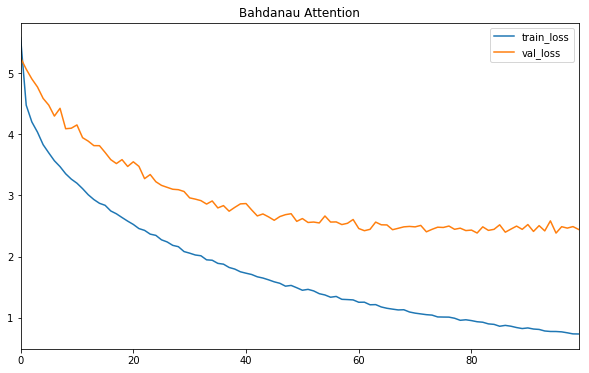

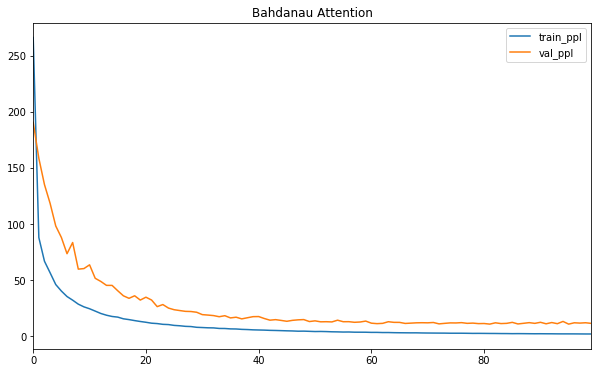

In [50]:
plot_metrics(bahdanau_training_metrics, "Bahdanau Attention", chart_filter='loss')
plot_metrics(bahdanau_training_metrics, "Bahdanau Attention", chart_filter='ppl')

In [69]:
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'bahdanau_model.pt')))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.333 | Test PPL:  10.305 |


input = you should try to see it .
output = vous devriez essayer de le voir . <eos>


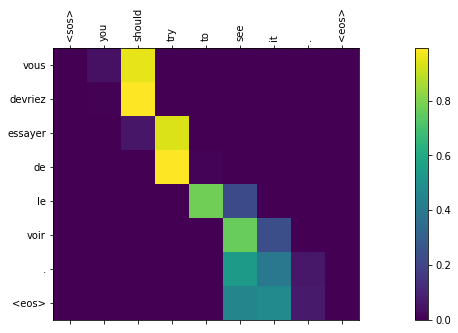

input = i m shorter than you .
output = je suis plus petite que vous . <eos>


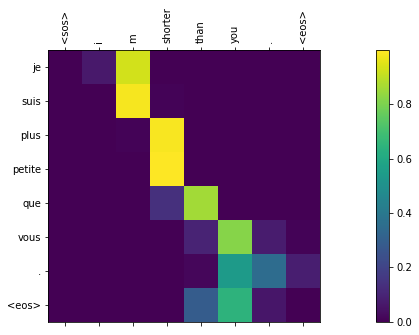

input = it was difficult for me .
output = il fut difficile difficile pour moi . <eos>


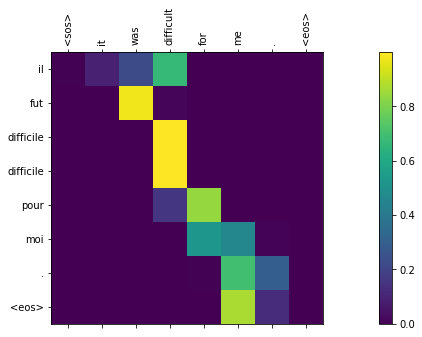

input = i don t follow .
output = je ne suis pas occupee . <eos>


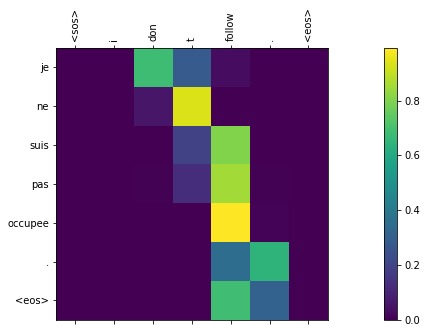

input = the region is relatively rich in mineral resources .
output = le <unk> <unk> riche dans <unk> <unk> . <eos>


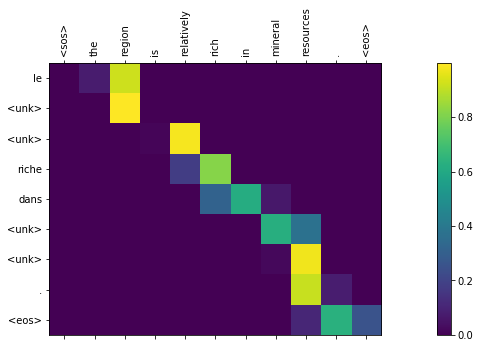

input = i took many photos and some of them were printed in black and white .
output = j ai pris part de en noir et blanc . <eos>


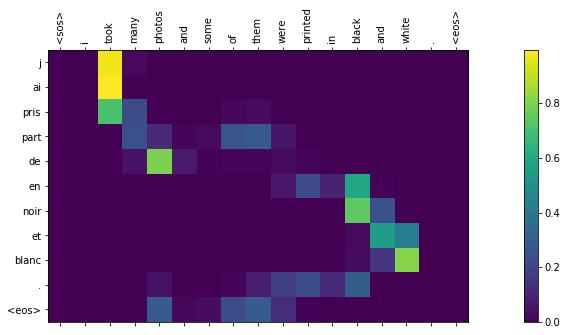

In [70]:
plt.rcParams['figure.figsize'] = [20, 5]
evaluateAndShowAttention(model, 'you should try to see it .')

evaluateAndShowAttention(model, 'i m shorter than you .')

evaluateAndShowAttention(model, 'it was difficult for me .')

evaluateAndShowAttention(model, 'i don t follow .')

evaluateAndShowAttention(model, 'the region is relatively rich in mineral resources .')

evaluateAndShowAttention(model, 'i took many photos and some of them were printed in black and white .')

In [95]:
import json

with open(os.path.join(SAVE_DIR, 'bahdanau_model.json'), 'w') as fp:
    json.dump(bahdanau_training_metrics, fp)

### 2.2.3 Global Attention

In [71]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, enc_hid_dim, dec_hid_dim, 
                 dropout, num_layers=1, bidirectional=False):
        super().__init__()
        
        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.dropout = dropout
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        
        self.embedding = nn.Embedding(input_dim, emb_dim)
        
        self.rnn = nn.GRU(emb_dim, enc_hid_dim, num_layers=num_layers, bidirectional=bidirectional)
        
        if bidirectional:
            self.fc = nn.Linear(enc_hid_dim * 2, dec_hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src):
        
        #src = [src sent len, batch size]
        
        embedded = self.dropout(self.embedding(src))
        
        #embedded = [src sent len, batch size, emb dim]
        
        outputs, hidden = self.rnn(embedded)
        
        if self.bidirectional:
            hidden = torch.tanh(self.fc(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)))
            
        if not self.bidirectional and self.num_layers > 1: 
            hidden = hidden[-1,:,:]                   
        
        return outputs, hidden

In [72]:
class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, enc_hid_dim, dec_hid_dim, dropout, 
                 attention, bidirectional_input=False):
        super().__init__()

        self.emb_dim = emb_dim
        self.enc_hid_dim = enc_hid_dim
        self.dec_hid_dim = dec_hid_dim
        self.output_dim = output_dim
        self.dropout = dropout
        self.attention = attention
        self.bidirectional_input = bidirectional_input
        
        self.embedding = nn.Embedding(output_dim, emb_dim)
        
        if bidirectional_input:
            self.rnn = nn.GRU((enc_hid_dim * 2) + emb_dim, dec_hid_dim)
            self.out = nn.Linear((enc_hid_dim * 2) + dec_hid_dim + emb_dim, output_dim)
        else:
            self.rnn = nn.GRU((enc_hid_dim) + emb_dim, dec_hid_dim)
            self.out = nn.Linear((enc_hid_dim) + dec_hid_dim + emb_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, input, hidden, encoder_outputs):
        #input = [batch size]
        #hidden = [batch size, dec hid dim]
        #encoder_outputs = [src sent len, batch size, enc hid dim * 2]
        
        input = input.unsqueeze(0)
        
        #input = [1, batch size]
        
        embedded = self.dropout(self.embedding(input))
        
        #embedded = [1, batch size, emb dim]
        
        hidden = hidden.squeeze(0) if len(hidden.size()) > 2 else hidden # batch_size=1 issue
       
        # Repeat hidden state for attention on bidirectional outputs
        if hidden.size(-1) != encoder_outputs.size(-1):
#             print("Hidden size: ", hidden.size())
#             print("Encoder outputs size: ", encoder_outputs.size())
            attn = self.attention(hidden.repeat(1, 2), encoder_outputs.permute(1, 0, 2))
        else:
            attn = self.attention(hidden, encoder_outputs.permute(1, 0, 2))

                
        #a = [batch size, src len]
        
        a = attn.unsqueeze(1)
        #a = [batch size, 1, src len]
        
        encoder_outputs = encoder_outputs.permute(1, 0, 2)
        
        #encoder_outputs = [batch size, src sent len, enc hid dim * 2]
        
        weighted = torch.bmm(a, encoder_outputs)
        
        #weighted = [batch size, 1, enc hid dim * 2]
        
        weighted = weighted.permute(1, 0, 2)
        
        #weighted = [1, batch size, enc hid dim * 2]
        
        rnn_input = torch.cat((embedded, weighted), dim=2)
        
        #rnn_input = [1, batch size, (enc hid dim * 2) + emb dim]
        
        output, hidden = self.rnn(rnn_input, hidden.unsqueeze(0))
        
        #output = [sent len, batch size, dec hid dim * n directions]
        #hidden = [n layers * n directions, batch size, dec hid dim]
        
        #sent len, n layers and n directions will always be 1 in this decoder, therefore:
        #output = [1, batch size, dec hid dim]
        #hidden = [1, batch size, dec hid dim]
        #this also means that output == hidden
        assert (output == hidden).all()
        
        embedded = embedded.squeeze(0)
        output = output.squeeze(0)
        weighted = weighted.squeeze(0)
        
        output = self.out(torch.cat((output, weighted, embedded), dim=1))
        
        #output = [bsz, output dim]
        
        return output, hidden.squeeze(0), attn

In [73]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        
    def forward(self, src, trg, teacher_forcing_ratio=0.5):
        
        #src = [src sent len, batch size]
        #trg = [trg sent len, batch size]
        #teacher_forcing_ratio is probability to use teacher forcing
        #e.g. if teacher_forcing_ratio is 0.75 we use teacher forcing 75% of the time
        
        batch_size = src.shape[1]
        max_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim
        
        #tensor to store decoder outputs
        outputs = torch.zeros(max_len, batch_size, trg_vocab_size).to(self.device)
        
        #encoder_outputs is all hidden states of the input sequence, back and forwards
        #hidden is the final forward and backward hidden states, passed through a linear layer
        encoder_outputs, hidden = self.encoder(src)
        hidden = hidden.squeeze(1)
        #first input to the decoder is the <sos> tokens
        output = trg[0,:]
        
        for t in range(1, max_len):
#             print("Hidden ", hidden.size())
            output, hidden, attn = self.decoder(output, hidden, encoder_outputs)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.max(1)[1]
            output = (trg[t] if teacher_force else top1)

        return outputs

### 2.2.4 Dot Product Attention

In [44]:
enc_bidirectional = True
enc_num_layers = 4

attn = DotProductAttention()
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, 
              num_layers=enc_num_layers, bidirectional=enc_bidirectional)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, 
              attn, bidirectional_input=enc_bidirectional)

model = Seq2Seq(enc, dec, device).to(device)

learning_rate = 0.01
decoder_learning_ratio = 5.0

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(enc.parameters(), lr=learning_rate, momentum=0.9)
decoder_optimizer = optim.SGD(dec.parameters(), lr=learning_rate * decoder_learning_ratio, momentum=0.9)
enc_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, 'min', patience=5)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, 'min', patience=5)

optimizer = MultipleOptimizer(encoder_optimizer, 
                        decoder_optimizer)

In [45]:
# Train
pad_idx = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'dot_model.pt')
dot_training_metrics = {}

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f} |')
    dot_training_metrics[epoch] = {'train_loss':train_loss, 'train_ppl':math.exp(train_loss), 'val_loss':valid_loss, 'val_ppl':math.exp(valid_loss)}

A Jupyter Widget


| Epoch: 001 | Train Loss: 5.625 | Train PPL: 277.213 | Val. Loss: 5.129 | Val. PPL: 168.882 |


A Jupyter Widget


| Epoch: 002 | Train Loss: 4.458 | Train PPL:  86.342 | Val. Loss: 4.927 | Val. PPL: 137.994 |


A Jupyter Widget


| Epoch: 003 | Train Loss: 4.141 | Train PPL:  62.892 | Val. Loss: 4.924 | Val. PPL: 137.548 |


A Jupyter Widget


| Epoch: 004 | Train Loss: 3.918 | Train PPL:  50.284 | Val. Loss: 4.924 | Val. PPL: 137.589 |


A Jupyter Widget


| Epoch: 005 | Train Loss: 3.789 | Train PPL:  44.222 | Val. Loss: 4.490 | Val. PPL:  89.150 |


A Jupyter Widget


| Epoch: 006 | Train Loss: 3.660 | Train PPL:  38.877 | Val. Loss: 4.473 | Val. PPL:  87.582 |


A Jupyter Widget


| Epoch: 007 | Train Loss: 3.513 | Train PPL:  33.552 | Val. Loss: 4.376 | Val. PPL:  79.533 |


A Jupyter Widget


| Epoch: 008 | Train Loss: 3.409 | Train PPL:  30.229 | Val. Loss: 4.265 | Val. PPL:  71.147 |


A Jupyter Widget


| Epoch: 009 | Train Loss: 3.330 | Train PPL:  27.949 | Val. Loss: 4.026 | Val. PPL:  56.059 |


A Jupyter Widget


| Epoch: 010 | Train Loss: 3.236 | Train PPL:  25.426 | Val. Loss: 4.100 | Val. PPL:  60.356 |


A Jupyter Widget


| Epoch: 011 | Train Loss: 3.137 | Train PPL:  23.038 | Val. Loss: 4.003 | Val. PPL:  54.741 |


A Jupyter Widget


| Epoch: 012 | Train Loss: 3.071 | Train PPL:  21.570 | Val. Loss: 3.960 | Val. PPL:  52.449 |


A Jupyter Widget


| Epoch: 013 | Train Loss: 2.974 | Train PPL:  19.579 | Val. Loss: 3.841 | Val. PPL:  46.585 |


A Jupyter Widget


| Epoch: 014 | Train Loss: 2.930 | Train PPL:  18.723 | Val. Loss: 3.761 | Val. PPL:  42.992 |


A Jupyter Widget


| Epoch: 015 | Train Loss: 2.863 | Train PPL:  17.522 | Val. Loss: 3.762 | Val. PPL:  43.054 |


A Jupyter Widget


| Epoch: 016 | Train Loss: 2.759 | Train PPL:  15.789 | Val. Loss: 3.648 | Val. PPL:  38.408 |


A Jupyter Widget


| Epoch: 017 | Train Loss: 2.740 | Train PPL:  15.489 | Val. Loss: 3.662 | Val. PPL:  38.922 |


A Jupyter Widget


| Epoch: 018 | Train Loss: 2.659 | Train PPL:  14.280 | Val. Loss: 3.562 | Val. PPL:  35.243 |


A Jupyter Widget


| Epoch: 019 | Train Loss: 2.623 | Train PPL:  13.772 | Val. Loss: 3.444 | Val. PPL:  31.312 |


A Jupyter Widget


| Epoch: 020 | Train Loss: 2.565 | Train PPL:  12.996 | Val. Loss: 3.455 | Val. PPL:  31.674 |


A Jupyter Widget


| Epoch: 021 | Train Loss: 2.508 | Train PPL:  12.281 | Val. Loss: 3.349 | Val. PPL:  28.484 |


A Jupyter Widget


| Epoch: 022 | Train Loss: 2.459 | Train PPL:  11.690 | Val. Loss: 3.374 | Val. PPL:  29.201 |


A Jupyter Widget


| Epoch: 023 | Train Loss: 2.408 | Train PPL:  11.110 | Val. Loss: 3.290 | Val. PPL:  26.847 |


A Jupyter Widget


| Epoch: 024 | Train Loss: 2.345 | Train PPL:  10.431 | Val. Loss: 3.220 | Val. PPL:  25.020 |


A Jupyter Widget


| Epoch: 025 | Train Loss: 2.307 | Train PPL:  10.044 | Val. Loss: 3.276 | Val. PPL:  26.465 |


A Jupyter Widget


| Epoch: 026 | Train Loss: 2.272 | Train PPL:   9.697 | Val. Loss: 3.091 | Val. PPL:  22.000 |


A Jupyter Widget


| Epoch: 027 | Train Loss: 2.218 | Train PPL:   9.188 | Val. Loss: 3.178 | Val. PPL:  23.989 |


A Jupyter Widget


| Epoch: 028 | Train Loss: 2.187 | Train PPL:   8.904 | Val. Loss: 3.060 | Val. PPL:  21.322 |


A Jupyter Widget


| Epoch: 029 | Train Loss: 2.130 | Train PPL:   8.414 | Val. Loss: 3.056 | Val. PPL:  21.244 |


A Jupyter Widget


| Epoch: 030 | Train Loss: 2.092 | Train PPL:   8.102 | Val. Loss: 2.932 | Val. PPL:  18.763 |


A Jupyter Widget


| Epoch: 031 | Train Loss: 2.054 | Train PPL:   7.799 | Val. Loss: 3.038 | Val. PPL:  20.868 |


A Jupyter Widget


| Epoch: 032 | Train Loss: 2.030 | Train PPL:   7.614 | Val. Loss: 2.944 | Val. PPL:  18.994 |


A Jupyter Widget


| Epoch: 033 | Train Loss: 1.999 | Train PPL:   7.382 | Val. Loss: 2.931 | Val. PPL:  18.744 |


A Jupyter Widget


| Epoch: 034 | Train Loss: 1.951 | Train PPL:   7.038 | Val. Loss: 2.933 | Val. PPL:  18.778 |


A Jupyter Widget


| Epoch: 035 | Train Loss: 1.924 | Train PPL:   6.848 | Val. Loss: 2.877 | Val. PPL:  17.754 |


A Jupyter Widget


| Epoch: 036 | Train Loss: 1.888 | Train PPL:   6.604 | Val. Loss: 2.849 | Val. PPL:  17.274 |


A Jupyter Widget


| Epoch: 037 | Train Loss: 1.870 | Train PPL:   6.488 | Val. Loss: 2.854 | Val. PPL:  17.349 |


A Jupyter Widget


| Epoch: 038 | Train Loss: 1.851 | Train PPL:   6.365 | Val. Loss: 2.803 | Val. PPL:  16.497 |


A Jupyter Widget


| Epoch: 039 | Train Loss: 1.798 | Train PPL:   6.041 | Val. Loss: 2.833 | Val. PPL:  16.989 |


A Jupyter Widget


| Epoch: 040 | Train Loss: 1.779 | Train PPL:   5.924 | Val. Loss: 2.830 | Val. PPL:  16.944 |


A Jupyter Widget


| Epoch: 041 | Train Loss: 1.750 | Train PPL:   5.754 | Val. Loss: 2.781 | Val. PPL:  16.137 |


A Jupyter Widget


| Epoch: 042 | Train Loss: 1.727 | Train PPL:   5.625 | Val. Loss: 2.674 | Val. PPL:  14.503 |


A Jupyter Widget


| Epoch: 043 | Train Loss: 1.692 | Train PPL:   5.430 | Val. Loss: 2.781 | Val. PPL:  16.138 |


A Jupyter Widget


| Epoch: 044 | Train Loss: 1.651 | Train PPL:   5.215 | Val. Loss: 2.721 | Val. PPL:  15.196 |


A Jupyter Widget


| Epoch: 045 | Train Loss: 1.639 | Train PPL:   5.151 | Val. Loss: 2.720 | Val. PPL:  15.177 |


A Jupyter Widget


| Epoch: 046 | Train Loss: 1.627 | Train PPL:   5.087 | Val. Loss: 2.670 | Val. PPL:  14.443 |


A Jupyter Widget


| Epoch: 047 | Train Loss: 1.611 | Train PPL:   5.009 | Val. Loss: 2.710 | Val. PPL:  15.025 |


A Jupyter Widget


| Epoch: 048 | Train Loss: 1.570 | Train PPL:   4.806 | Val. Loss: 2.627 | Val. PPL:  13.834 |


A Jupyter Widget


| Epoch: 049 | Train Loss: 1.530 | Train PPL:   4.620 | Val. Loss: 2.726 | Val. PPL:  15.279 |


A Jupyter Widget


| Epoch: 050 | Train Loss: 1.534 | Train PPL:   4.636 | Val. Loss: 2.649 | Val. PPL:  14.134 |


A Jupyter Widget


| Epoch: 051 | Train Loss: 1.485 | Train PPL:   4.413 | Val. Loss: 2.622 | Val. PPL:  13.769 |


A Jupyter Widget


| Epoch: 052 | Train Loss: 1.466 | Train PPL:   4.331 | Val. Loss: 2.620 | Val. PPL:  13.735 |


A Jupyter Widget


| Epoch: 053 | Train Loss: 1.456 | Train PPL:   4.287 | Val. Loss: 2.524 | Val. PPL:  12.476 |


A Jupyter Widget


| Epoch: 054 | Train Loss: 1.412 | Train PPL:   4.104 | Val. Loss: 2.646 | Val. PPL:  14.102 |


A Jupyter Widget


| Epoch: 055 | Train Loss: 1.395 | Train PPL:   4.035 | Val. Loss: 2.526 | Val. PPL:  12.502 |


A Jupyter Widget


| Epoch: 056 | Train Loss: 1.405 | Train PPL:   4.077 | Val. Loss: 2.536 | Val. PPL:  12.630 |


A Jupyter Widget


| Epoch: 057 | Train Loss: 1.394 | Train PPL:   4.032 | Val. Loss: 2.482 | Val. PPL:  11.971 |


A Jupyter Widget


| Epoch: 058 | Train Loss: 1.353 | Train PPL:   3.869 | Val. Loss: 2.546 | Val. PPL:  12.756 |


A Jupyter Widget


| Epoch: 059 | Train Loss: 1.345 | Train PPL:   3.839 | Val. Loss: 2.557 | Val. PPL:  12.899 |


A Jupyter Widget


| Epoch: 060 | Train Loss: 1.301 | Train PPL:   3.674 | Val. Loss: 2.534 | Val. PPL:  12.607 |


A Jupyter Widget


| Epoch: 061 | Train Loss: 1.296 | Train PPL:   3.655 | Val. Loss: 2.640 | Val. PPL:  14.009 |


A Jupyter Widget


| Epoch: 062 | Train Loss: 1.303 | Train PPL:   3.681 | Val. Loss: 2.541 | Val. PPL:  12.687 |


A Jupyter Widget


| Epoch: 063 | Train Loss: 1.263 | Train PPL:   3.537 | Val. Loss: 2.508 | Val. PPL:  12.277 |


A Jupyter Widget


| Epoch: 064 | Train Loss: 1.249 | Train PPL:   3.487 | Val. Loss: 2.491 | Val. PPL:  12.074 |


A Jupyter Widget


| Epoch: 065 | Train Loss: 1.237 | Train PPL:   3.446 | Val. Loss: 2.502 | Val. PPL:  12.203 |


A Jupyter Widget


| Epoch: 066 | Train Loss: 1.231 | Train PPL:   3.425 | Val. Loss: 2.483 | Val. PPL:  11.980 |


A Jupyter Widget


| Epoch: 067 | Train Loss: 1.205 | Train PPL:   3.338 | Val. Loss: 2.430 | Val. PPL:  11.364 |


A Jupyter Widget


| Epoch: 068 | Train Loss: 1.187 | Train PPL:   3.276 | Val. Loss: 2.458 | Val. PPL:  11.680 |


A Jupyter Widget


| Epoch: 069 | Train Loss: 1.172 | Train PPL:   3.228 | Val. Loss: 2.419 | Val. PPL:  11.238 |


A Jupyter Widget


| Epoch: 070 | Train Loss: 1.161 | Train PPL:   3.193 | Val. Loss: 2.463 | Val. PPL:  11.744 |


A Jupyter Widget


| Epoch: 071 | Train Loss: 1.144 | Train PPL:   3.140 | Val. Loss: 2.455 | Val. PPL:  11.643 |


A Jupyter Widget


| Epoch: 072 | Train Loss: 1.131 | Train PPL:   3.098 | Val. Loss: 2.459 | Val. PPL:  11.697 |


A Jupyter Widget


| Epoch: 073 | Train Loss: 1.106 | Train PPL:   3.023 | Val. Loss: 2.435 | Val. PPL:  11.419 |


A Jupyter Widget


| Epoch: 074 | Train Loss: 1.080 | Train PPL:   2.943 | Val. Loss: 2.440 | Val. PPL:  11.468 |


A Jupyter Widget


| Epoch: 075 | Train Loss: 1.100 | Train PPL:   3.005 | Val. Loss: 2.446 | Val. PPL:  11.536 |


A Jupyter Widget


| Epoch: 076 | Train Loss: 1.056 | Train PPL:   2.875 | Val. Loss: 2.449 | Val. PPL:  11.573 |


A Jupyter Widget


| Epoch: 077 | Train Loss: 1.063 | Train PPL:   2.894 | Val. Loss: 2.343 | Val. PPL:  10.413 |


A Jupyter Widget


| Epoch: 078 | Train Loss: 1.043 | Train PPL:   2.838 | Val. Loss: 2.430 | Val. PPL:  11.365 |


A Jupyter Widget


| Epoch: 079 | Train Loss: 1.023 | Train PPL:   2.782 | Val. Loss: 2.468 | Val. PPL:  11.804 |


A Jupyter Widget


| Epoch: 080 | Train Loss: 1.012 | Train PPL:   2.751 | Val. Loss: 2.423 | Val. PPL:  11.280 |


A Jupyter Widget


| Epoch: 081 | Train Loss: 0.996 | Train PPL:   2.708 | Val. Loss: 2.479 | Val. PPL:  11.934 |


A Jupyter Widget


| Epoch: 082 | Train Loss: 0.969 | Train PPL:   2.637 | Val. Loss: 2.434 | Val. PPL:  11.409 |


A Jupyter Widget


| Epoch: 083 | Train Loss: 0.976 | Train PPL:   2.653 | Val. Loss: 2.373 | Val. PPL:  10.726 |


A Jupyter Widget


| Epoch: 084 | Train Loss: 0.959 | Train PPL:   2.609 | Val. Loss: 2.395 | Val. PPL:  10.963 |


A Jupyter Widget


| Epoch: 085 | Train Loss: 0.948 | Train PPL:   2.581 | Val. Loss: 2.425 | Val. PPL:  11.306 |


A Jupyter Widget


| Epoch: 086 | Train Loss: 0.925 | Train PPL:   2.523 | Val. Loss: 2.410 | Val. PPL:  11.132 |


A Jupyter Widget


| Epoch: 087 | Train Loss: 0.922 | Train PPL:   2.513 | Val. Loss: 2.383 | Val. PPL:  10.834 |


A Jupyter Widget


| Epoch: 088 | Train Loss: 0.914 | Train PPL:   2.494 | Val. Loss: 2.409 | Val. PPL:  11.128 |


A Jupyter Widget


| Epoch: 089 | Train Loss: 0.914 | Train PPL:   2.495 | Val. Loss: 2.420 | Val. PPL:  11.241 |


A Jupyter Widget


| Epoch: 090 | Train Loss: 0.892 | Train PPL:   2.440 | Val. Loss: 2.430 | Val. PPL:  11.362 |


A Jupyter Widget


| Epoch: 091 | Train Loss: 0.888 | Train PPL:   2.431 | Val. Loss: 2.384 | Val. PPL:  10.844 |


A Jupyter Widget


| Epoch: 092 | Train Loss: 0.869 | Train PPL:   2.385 | Val. Loss: 2.374 | Val. PPL:  10.741 |


A Jupyter Widget


| Epoch: 093 | Train Loss: 0.870 | Train PPL:   2.388 | Val. Loss: 2.420 | Val. PPL:  11.246 |


A Jupyter Widget


| Epoch: 094 | Train Loss: 0.841 | Train PPL:   2.318 | Val. Loss: 2.460 | Val. PPL:  11.705 |


A Jupyter Widget


| Epoch: 095 | Train Loss: 0.846 | Train PPL:   2.331 | Val. Loss: 2.369 | Val. PPL:  10.690 |


A Jupyter Widget


| Epoch: 096 | Train Loss: 0.819 | Train PPL:   2.268 | Val. Loss: 2.395 | Val. PPL:  10.972 |


A Jupyter Widget


| Epoch: 097 | Train Loss: 0.816 | Train PPL:   2.262 | Val. Loss: 2.450 | Val. PPL:  11.586 |


A Jupyter Widget


| Epoch: 098 | Train Loss: 0.828 | Train PPL:   2.288 | Val. Loss: 2.372 | Val. PPL:  10.719 |


A Jupyter Widget


| Epoch: 099 | Train Loss: 0.791 | Train PPL:   2.206 | Val. Loss: 2.413 | Val. PPL:  11.168 |


A Jupyter Widget


| Epoch: 100 | Train Loss: 0.797 | Train PPL:   2.218 | Val. Loss: 2.379 | Val. PPL:  10.793 |


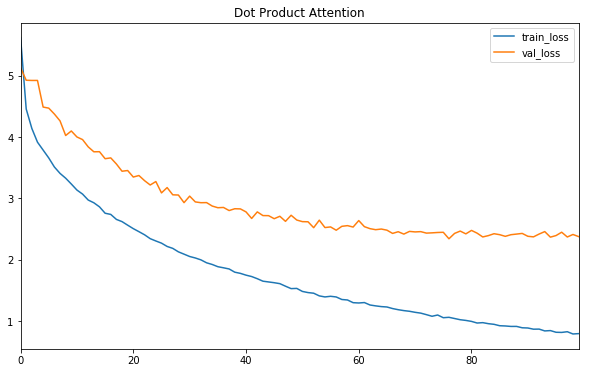

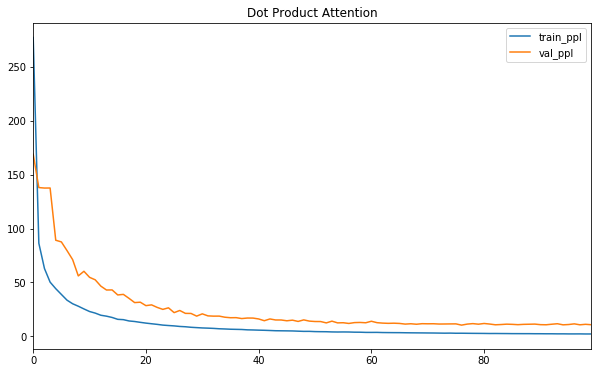

In [46]:
plot_metrics(dot_training_metrics, "Dot Product Attention", chart_filter='loss')
plot_metrics(dot_training_metrics, "Dot Product Attention", chart_filter='ppl')

In [47]:
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'dot_model.pt')))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.271 | Test PPL:   9.686 |


In [48]:
import json

with open(os.path.join(SAVE_DIR, 'dot_model.json'), 'w') as fp:
    json.dump(dot_training_metrics, fp)

input = you should try to see it .
output = vous devriez essayer de le voir . <eos>


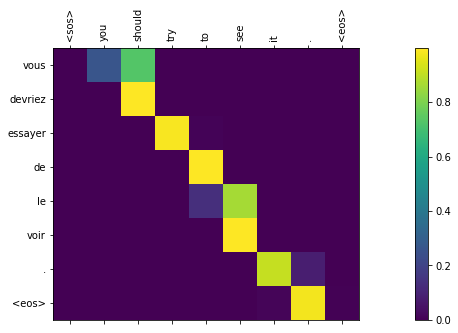

input = i m shorter than you .
output = je suis plus petit que vous . <eos>


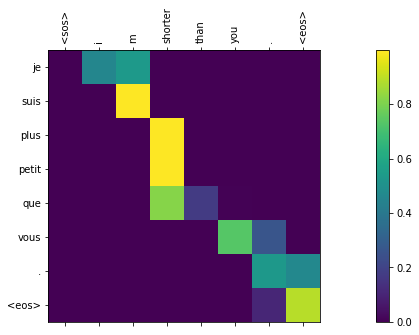

input = it was difficult for me .
output = c etait difficile difficile pour moi . <eos>


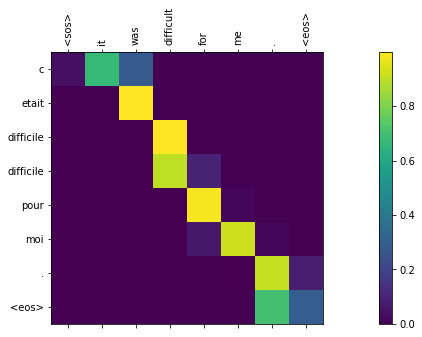

input = i don t follow .
output = je ne suis pas pas . <eos>


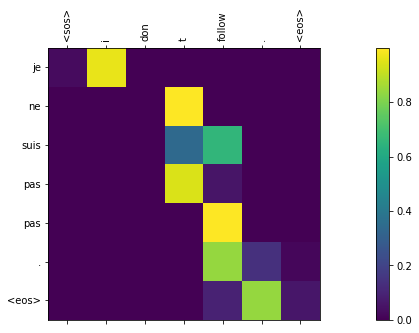

input = the region is relatively rich in mineral resources .
output = le pont s riche riche en <unk> . <eos>


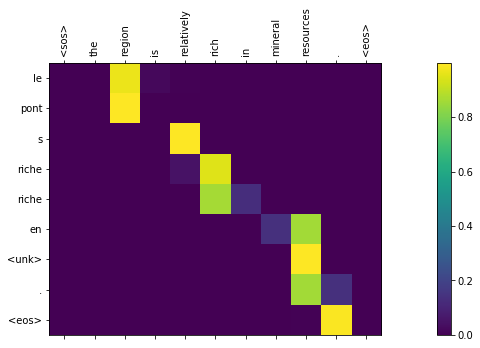

input = i took many photos and some of them were printed in black and white .
output = j ai beaucoup nombreux et et des <unk> . <eos>


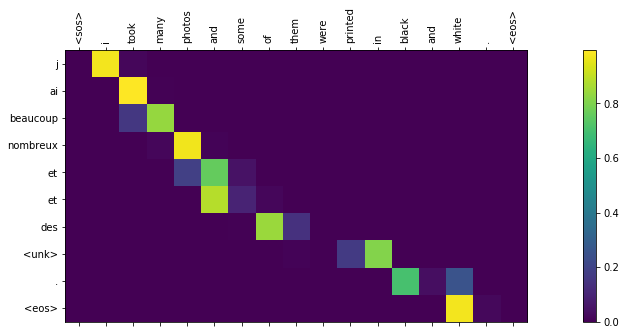

In [57]:
plt.rcParams['figure.figsize'] = [20, 5]
evaluateAndShowAttention(model, 'you should try to see it .')

evaluateAndShowAttention(model, 'i m shorter than you .')

evaluateAndShowAttention(model, 'it was difficult for me .')

evaluateAndShowAttention(model, 'i don t follow .')

evaluateAndShowAttention(model, 'the region is relatively rich in mineral resources .')

evaluateAndShowAttention(model, 'i took many photos and some of them were printed in black and white .')

### 2.2.5 Cosine Attention

In [74]:
enc_bidirectional = True
enc_num_layers = 4

attn = CosineAttention()
enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, 
              num_layers=enc_num_layers, bidirectional=enc_bidirectional)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, 
              attn, bidirectional_input=enc_bidirectional)

model = Seq2Seq(enc, dec, device).to(device)

learning_rate = 0.01
decoder_learning_ratio = 5.0

# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(enc.parameters(), lr=learning_rate, momentum=0.9)
decoder_optimizer = optim.SGD(dec.parameters(), lr=learning_rate * decoder_learning_ratio, momentum=0.9)
enc_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, 'min', patience=5)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, 'min', patience=5)

optimizer = MultipleOptimizer(encoder_optimizer, 
                        decoder_optimizer)

In [75]:
# Train
pad_idx = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'cosine_model.pt')
cosine_training_metrics = {}

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f} |')
    cosine_training_metrics[epoch] = {'train_loss':train_loss, 'train_ppl':math.exp(train_loss), 'val_loss':valid_loss, 'val_ppl':math.exp(valid_loss)}

A Jupyter Widget


| Epoch: 001 | Train Loss: 5.789 | Train PPL: 326.744 | Val. Loss: 5.139 | Val. PPL: 170.489 |


A Jupyter Widget


| Epoch: 002 | Train Loss: 4.548 | Train PPL:  94.489 | Val. Loss: 4.952 | Val. PPL: 141.524 |


A Jupyter Widget


| Epoch: 003 | Train Loss: 4.303 | Train PPL:  73.921 | Val. Loss: 4.919 | Val. PPL: 136.900 |


A Jupyter Widget


| Epoch: 004 | Train Loss: 4.123 | Train PPL:  61.766 | Val. Loss: 4.817 | Val. PPL: 123.560 |


A Jupyter Widget


| Epoch: 005 | Train Loss: 3.979 | Train PPL:  53.465 | Val. Loss: 4.691 | Val. PPL: 108.968 |


A Jupyter Widget


| Epoch: 006 | Train Loss: 3.867 | Train PPL:  47.806 | Val. Loss: 4.623 | Val. PPL: 101.839 |


A Jupyter Widget


| Epoch: 007 | Train Loss: 3.770 | Train PPL:  43.378 | Val. Loss: 4.719 | Val. PPL: 112.083 |


A Jupyter Widget


| Epoch: 008 | Train Loss: 3.648 | Train PPL:  38.417 | Val. Loss: 4.656 | Val. PPL: 105.242 |


A Jupyter Widget


| Epoch: 009 | Train Loss: 3.594 | Train PPL:  36.386 | Val. Loss: 4.511 | Val. PPL:  91.029 |


A Jupyter Widget


| Epoch: 010 | Train Loss: 3.505 | Train PPL:  33.272 | Val. Loss: 4.468 | Val. PPL:  87.185 |


A Jupyter Widget


| Epoch: 011 | Train Loss: 3.458 | Train PPL:  31.763 | Val. Loss: 4.470 | Val. PPL:  87.390 |


A Jupyter Widget


| Epoch: 012 | Train Loss: 3.413 | Train PPL:  30.347 | Val. Loss: 4.372 | Val. PPL:  79.198 |


A Jupyter Widget


| Epoch: 013 | Train Loss: 3.324 | Train PPL:  27.762 | Val. Loss: 4.385 | Val. PPL:  80.258 |


A Jupyter Widget


| Epoch: 014 | Train Loss: 3.289 | Train PPL:  26.804 | Val. Loss: 4.292 | Val. PPL:  73.101 |


A Jupyter Widget


| Epoch: 015 | Train Loss: 3.224 | Train PPL:  25.121 | Val. Loss: 4.202 | Val. PPL:  66.828 |


A Jupyter Widget


| Epoch: 016 | Train Loss: 3.151 | Train PPL:  23.349 | Val. Loss: 4.299 | Val. PPL:  73.657 |


A Jupyter Widget


| Epoch: 017 | Train Loss: 3.082 | Train PPL:  21.806 | Val. Loss: 4.186 | Val. PPL:  65.738 |


A Jupyter Widget


| Epoch: 018 | Train Loss: 3.042 | Train PPL:  20.941 | Val. Loss: 4.065 | Val. PPL:  58.252 |


A Jupyter Widget


| Epoch: 019 | Train Loss: 3.008 | Train PPL:  20.240 | Val. Loss: 4.034 | Val. PPL:  56.460 |


A Jupyter Widget


| Epoch: 020 | Train Loss: 2.958 | Train PPL:  19.265 | Val. Loss: 4.123 | Val. PPL:  61.723 |


A Jupyter Widget


| Epoch: 021 | Train Loss: 2.883 | Train PPL:  17.869 | Val. Loss: 3.975 | Val. PPL:  53.258 |


A Jupyter Widget


| Epoch: 022 | Train Loss: 2.849 | Train PPL:  17.265 | Val. Loss: 3.969 | Val. PPL:  52.940 |


A Jupyter Widget


| Epoch: 023 | Train Loss: 2.798 | Train PPL:  16.418 | Val. Loss: 3.910 | Val. PPL:  49.910 |


A Jupyter Widget


| Epoch: 024 | Train Loss: 2.756 | Train PPL:  15.730 | Val. Loss: 3.969 | Val. PPL:  52.957 |


A Jupyter Widget


| Epoch: 025 | Train Loss: 2.707 | Train PPL:  14.979 | Val. Loss: 3.830 | Val. PPL:  46.074 |


A Jupyter Widget


| Epoch: 026 | Train Loss: 2.672 | Train PPL:  14.467 | Val. Loss: 3.759 | Val. PPL:  42.905 |


A Jupyter Widget


| Epoch: 027 | Train Loss: 2.629 | Train PPL:  13.862 | Val. Loss: 3.842 | Val. PPL:  46.625 |


A Jupyter Widget


| Epoch: 028 | Train Loss: 2.585 | Train PPL:  13.261 | Val. Loss: 3.758 | Val. PPL:  42.873 |


A Jupyter Widget


| Epoch: 029 | Train Loss: 2.567 | Train PPL:  13.027 | Val. Loss: 3.704 | Val. PPL:  40.629 |


A Jupyter Widget


| Epoch: 030 | Train Loss: 2.536 | Train PPL:  12.632 | Val. Loss: 3.711 | Val. PPL:  40.894 |


A Jupyter Widget


| Epoch: 031 | Train Loss: 2.500 | Train PPL:  12.183 | Val. Loss: 3.598 | Val. PPL:  36.508 |


A Jupyter Widget


| Epoch: 032 | Train Loss: 2.435 | Train PPL:  11.413 | Val. Loss: 3.699 | Val. PPL:  40.423 |


A Jupyter Widget


| Epoch: 033 | Train Loss: 2.441 | Train PPL:  11.485 | Val. Loss: 3.645 | Val. PPL:  38.274 |


A Jupyter Widget


| Epoch: 034 | Train Loss: 2.410 | Train PPL:  11.137 | Val. Loss: 3.731 | Val. PPL:  41.727 |


A Jupyter Widget


| Epoch: 035 | Train Loss: 2.391 | Train PPL:  10.920 | Val. Loss: 3.614 | Val. PPL:  37.120 |


A Jupyter Widget


| Epoch: 036 | Train Loss: 2.327 | Train PPL:  10.244 | Val. Loss: 3.542 | Val. PPL:  34.551 |


A Jupyter Widget


| Epoch: 037 | Train Loss: 2.309 | Train PPL:  10.069 | Val. Loss: 3.485 | Val. PPL:  32.623 |


A Jupyter Widget


| Epoch: 038 | Train Loss: 2.257 | Train PPL:   9.557 | Val. Loss: 3.526 | Val. PPL:  33.972 |


A Jupyter Widget


| Epoch: 039 | Train Loss: 2.255 | Train PPL:   9.533 | Val. Loss: 3.481 | Val. PPL:  32.504 |


A Jupyter Widget


| Epoch: 040 | Train Loss: 2.198 | Train PPL:   9.003 | Val. Loss: 3.518 | Val. PPL:  33.722 |


A Jupyter Widget


| Epoch: 041 | Train Loss: 2.224 | Train PPL:   9.246 | Val. Loss: 3.412 | Val. PPL:  30.320 |


A Jupyter Widget


| Epoch: 042 | Train Loss: 2.144 | Train PPL:   8.531 | Val. Loss: 3.414 | Val. PPL:  30.391 |


A Jupyter Widget


| Epoch: 043 | Train Loss: 2.122 | Train PPL:   8.350 | Val. Loss: 3.324 | Val. PPL:  27.781 |


A Jupyter Widget


| Epoch: 044 | Train Loss: 2.117 | Train PPL:   8.303 | Val. Loss: 3.431 | Val. PPL:  30.896 |


A Jupyter Widget


| Epoch: 045 | Train Loss: 2.090 | Train PPL:   8.088 | Val. Loss: 3.384 | Val. PPL:  29.497 |


A Jupyter Widget


| Epoch: 046 | Train Loss: 2.034 | Train PPL:   7.641 | Val. Loss: 3.354 | Val. PPL:  28.605 |


A Jupyter Widget


| Epoch: 047 | Train Loss: 2.031 | Train PPL:   7.625 | Val. Loss: 3.315 | Val. PPL:  27.515 |


A Jupyter Widget


| Epoch: 048 | Train Loss: 1.997 | Train PPL:   7.369 | Val. Loss: 3.222 | Val. PPL:  25.085 |


A Jupyter Widget


| Epoch: 049 | Train Loss: 1.968 | Train PPL:   7.153 | Val. Loss: 3.301 | Val. PPL:  27.147 |


A Jupyter Widget


| Epoch: 050 | Train Loss: 1.944 | Train PPL:   6.984 | Val. Loss: 3.263 | Val. PPL:  26.122 |


A Jupyter Widget


| Epoch: 051 | Train Loss: 1.910 | Train PPL:   6.751 | Val. Loss: 3.195 | Val. PPL:  24.413 |


A Jupyter Widget


| Epoch: 052 | Train Loss: 1.897 | Train PPL:   6.664 | Val. Loss: 3.247 | Val. PPL:  25.705 |


A Jupyter Widget


| Epoch: 053 | Train Loss: 1.873 | Train PPL:   6.506 | Val. Loss: 3.258 | Val. PPL:  26.004 |


A Jupyter Widget


| Epoch: 054 | Train Loss: 1.833 | Train PPL:   6.255 | Val. Loss: 3.241 | Val. PPL:  25.566 |


A Jupyter Widget


| Epoch: 055 | Train Loss: 1.828 | Train PPL:   6.223 | Val. Loss: 3.219 | Val. PPL:  25.012 |


A Jupyter Widget


| Epoch: 056 | Train Loss: 1.813 | Train PPL:   6.127 | Val. Loss: 3.297 | Val. PPL:  27.034 |


A Jupyter Widget


| Epoch: 057 | Train Loss: 1.786 | Train PPL:   5.968 | Val. Loss: 3.245 | Val. PPL:  25.649 |


A Jupyter Widget


| Epoch: 058 | Train Loss: 1.751 | Train PPL:   5.760 | Val. Loss: 3.183 | Val. PPL:  24.119 |


A Jupyter Widget


| Epoch: 059 | Train Loss: 1.739 | Train PPL:   5.692 | Val. Loss: 3.130 | Val. PPL:  22.871 |


A Jupyter Widget


| Epoch: 060 | Train Loss: 1.727 | Train PPL:   5.621 | Val. Loss: 3.148 | Val. PPL:  23.296 |


A Jupyter Widget


| Epoch: 061 | Train Loss: 1.701 | Train PPL:   5.478 | Val. Loss: 3.146 | Val. PPL:  23.240 |


A Jupyter Widget


| Epoch: 062 | Train Loss: 1.679 | Train PPL:   5.361 | Val. Loss: 3.161 | Val. PPL:  23.603 |


A Jupyter Widget


| Epoch: 063 | Train Loss: 1.649 | Train PPL:   5.199 | Val. Loss: 3.071 | Val. PPL:  21.566 |


A Jupyter Widget


| Epoch: 064 | Train Loss: 1.630 | Train PPL:   5.106 | Val. Loss: 3.092 | Val. PPL:  22.026 |


A Jupyter Widget


| Epoch: 065 | Train Loss: 1.610 | Train PPL:   5.000 | Val. Loss: 3.117 | Val. PPL:  22.586 |


A Jupyter Widget


| Epoch: 066 | Train Loss: 1.598 | Train PPL:   4.945 | Val. Loss: 3.167 | Val. PPL:  23.727 |


A Jupyter Widget


| Epoch: 067 | Train Loss: 1.570 | Train PPL:   4.807 | Val. Loss: 3.111 | Val. PPL:  22.442 |


A Jupyter Widget


| Epoch: 068 | Train Loss: 1.556 | Train PPL:   4.742 | Val. Loss: 3.057 | Val. PPL:  21.264 |


A Jupyter Widget


| Epoch: 069 | Train Loss: 1.536 | Train PPL:   4.645 | Val. Loss: 3.185 | Val. PPL:  24.164 |


A Jupyter Widget


| Epoch: 070 | Train Loss: 1.517 | Train PPL:   4.559 | Val. Loss: 3.071 | Val. PPL:  21.562 |


A Jupyter Widget


| Epoch: 071 | Train Loss: 1.475 | Train PPL:   4.372 | Val. Loss: 3.052 | Val. PPL:  21.159 |


A Jupyter Widget


| Epoch: 072 | Train Loss: 1.482 | Train PPL:   4.401 | Val. Loss: 3.092 | Val. PPL:  22.023 |


A Jupyter Widget


| Epoch: 073 | Train Loss: 1.461 | Train PPL:   4.311 | Val. Loss: 3.011 | Val. PPL:  20.317 |


A Jupyter Widget


| Epoch: 074 | Train Loss: 1.448 | Train PPL:   4.254 | Val. Loss: 3.050 | Val. PPL:  21.122 |


A Jupyter Widget


| Epoch: 075 | Train Loss: 1.426 | Train PPL:   4.163 | Val. Loss: 3.033 | Val. PPL:  20.754 |


A Jupyter Widget


| Epoch: 076 | Train Loss: 1.419 | Train PPL:   4.133 | Val. Loss: 2.989 | Val. PPL:  19.863 |


A Jupyter Widget


| Epoch: 077 | Train Loss: 1.399 | Train PPL:   4.051 | Val. Loss: 3.063 | Val. PPL:  21.383 |


A Jupyter Widget


| Epoch: 078 | Train Loss: 1.370 | Train PPL:   3.937 | Val. Loss: 3.118 | Val. PPL:  22.592 |


A Jupyter Widget


| Epoch: 079 | Train Loss: 1.369 | Train PPL:   3.933 | Val. Loss: 3.056 | Val. PPL:  21.250 |


A Jupyter Widget


| Epoch: 080 | Train Loss: 1.328 | Train PPL:   3.775 | Val. Loss: 2.975 | Val. PPL:  19.598 |


A Jupyter Widget


| Epoch: 081 | Train Loss: 1.333 | Train PPL:   3.791 | Val. Loss: 2.973 | Val. PPL:  19.542 |


A Jupyter Widget


| Epoch: 082 | Train Loss: 1.314 | Train PPL:   3.720 | Val. Loss: 3.003 | Val. PPL:  20.143 |


A Jupyter Widget


| Epoch: 083 | Train Loss: 1.308 | Train PPL:   3.698 | Val. Loss: 3.018 | Val. PPL:  20.444 |


A Jupyter Widget


| Epoch: 084 | Train Loss: 1.293 | Train PPL:   3.642 | Val. Loss: 3.005 | Val. PPL:  20.177 |


A Jupyter Widget


| Epoch: 085 | Train Loss: 1.282 | Train PPL:   3.604 | Val. Loss: 3.104 | Val. PPL:  22.279 |


A Jupyter Widget


| Epoch: 086 | Train Loss: 1.256 | Train PPL:   3.511 | Val. Loss: 2.927 | Val. PPL:  18.663 |


A Jupyter Widget


| Epoch: 087 | Train Loss: 1.261 | Train PPL:   3.529 | Val. Loss: 3.011 | Val. PPL:  20.303 |


A Jupyter Widget


| Epoch: 088 | Train Loss: 1.216 | Train PPL:   3.375 | Val. Loss: 2.959 | Val. PPL:  19.273 |


A Jupyter Widget


| Epoch: 089 | Train Loss: 1.206 | Train PPL:   3.339 | Val. Loss: 3.088 | Val. PPL:  21.938 |


A Jupyter Widget


| Epoch: 090 | Train Loss: 1.182 | Train PPL:   3.261 | Val. Loss: 2.947 | Val. PPL:  19.042 |


A Jupyter Widget


| Epoch: 091 | Train Loss: 1.181 | Train PPL:   3.258 | Val. Loss: 2.942 | Val. PPL:  18.958 |


A Jupyter Widget


| Epoch: 092 | Train Loss: 1.182 | Train PPL:   3.262 | Val. Loss: 2.990 | Val. PPL:  19.886 |


A Jupyter Widget


| Epoch: 093 | Train Loss: 1.167 | Train PPL:   3.214 | Val. Loss: 2.959 | Val. PPL:  19.282 |


A Jupyter Widget


| Epoch: 094 | Train Loss: 1.140 | Train PPL:   3.128 | Val. Loss: 2.944 | Val. PPL:  19.001 |


A Jupyter Widget


| Epoch: 095 | Train Loss: 1.123 | Train PPL:   3.074 | Val. Loss: 3.004 | Val. PPL:  20.157 |


A Jupyter Widget


| Epoch: 096 | Train Loss: 1.131 | Train PPL:   3.099 | Val. Loss: 2.941 | Val. PPL:  18.932 |


A Jupyter Widget


| Epoch: 097 | Train Loss: 1.085 | Train PPL:   2.959 | Val. Loss: 3.008 | Val. PPL:  20.250 |


A Jupyter Widget


| Epoch: 098 | Train Loss: 1.108 | Train PPL:   3.027 | Val. Loss: 2.926 | Val. PPL:  18.649 |


A Jupyter Widget


| Epoch: 099 | Train Loss: 1.087 | Train PPL:   2.964 | Val. Loss: 2.883 | Val. PPL:  17.864 |


A Jupyter Widget


| Epoch: 100 | Train Loss: 1.065 | Train PPL:   2.900 | Val. Loss: 2.906 | Val. PPL:  18.280 |


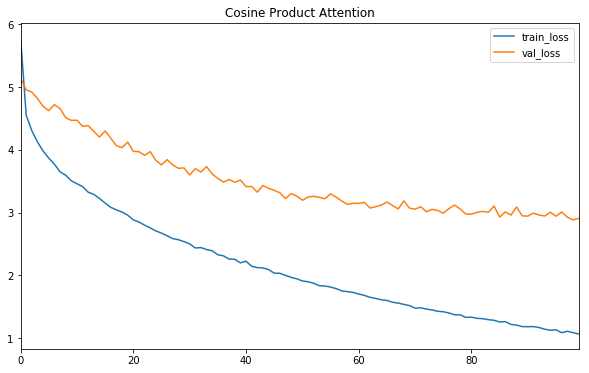

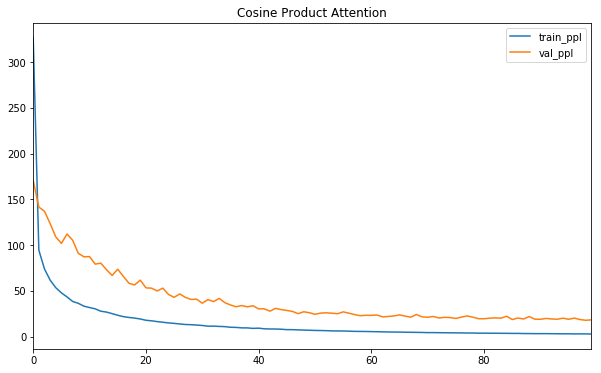

In [76]:
plot_metrics(cosine_training_metrics, "Cosine Product Attention", chart_filter='loss')
plot_metrics(cosine_training_metrics, "Cosine Product Attention", chart_filter='ppl')

In [77]:
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'cosine_model.pt')))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.803 | Test PPL:  16.497 |


In [78]:
import json

with open(os.path.join(SAVE_DIR, 'cosine_model.json'), 'w') as fp:
    json.dump(cosine_training_metrics, fp)

input = you should try to see it .
output = tu devrais essayer de le voir . <eos>


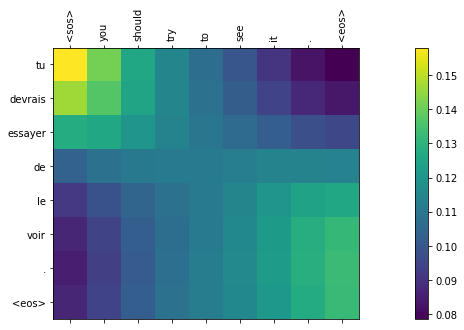

input = i m shorter than you .
output = je suis plus jeune que vous vous . <eos>


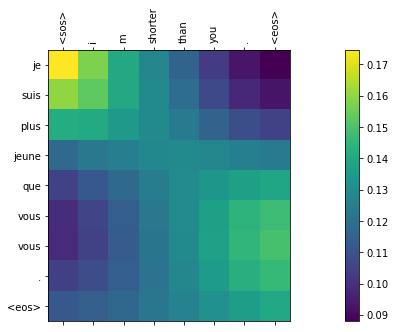

input = it was difficult for me .
output = c etait ete difficile de moi . <eos>


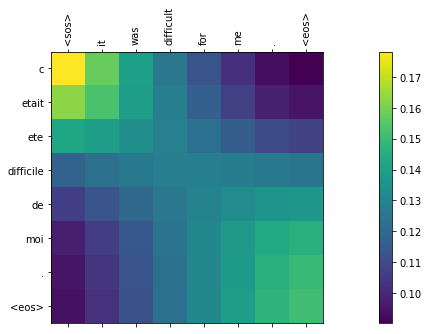

input = i don t follow .
output = je ne suis pas pas d humeur . <eos>


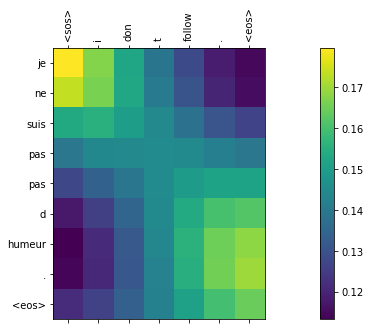

input = the region is relatively rich in mineral resources .
output = le japon est <unk> dans l <unk> <unk> . <eos>


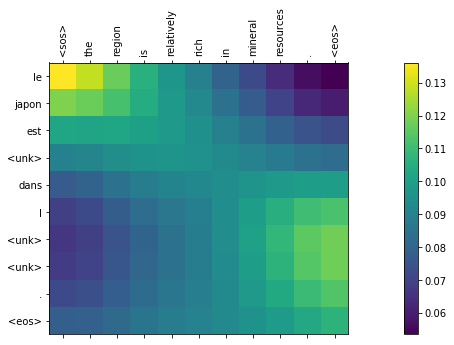

input = i took many photos and some of them were printed in black and white .
output = je pris beaucoup d entre et et blanc . <eos>


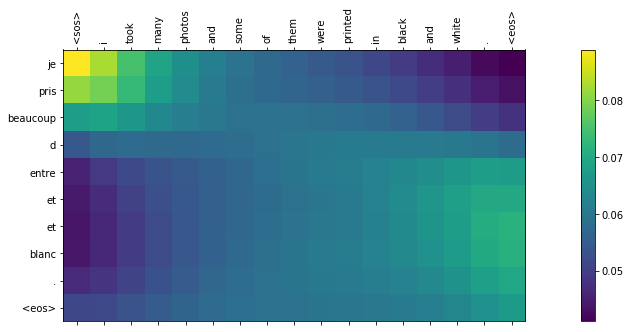

In [79]:
evaluateAndShowAttention(model, 'you should try to see it .')

evaluateAndShowAttention(model, 'i m shorter than you .')

evaluateAndShowAttention(model, 'it was difficult for me .')

evaluateAndShowAttention(model, 'i don t follow .')

evaluateAndShowAttention(model, 'the region is relatively rich in mineral resources .')

evaluateAndShowAttention(model, 'i took many photos and some of them were printed in black and white .')

### 2.2.6 Bilinear Attention

In [80]:
enc_bidirectional = True
enc_num_layers = 4

# attn = BilinearAttention(ENC_HID_DIM, DEC_HID_DIM) # Uni-directional attention
attn = BilinearAttention((ENC_HID_DIM * 2), (ENC_HID_DIM * 2)) # Bi-directional attention

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, 
              num_layers=enc_num_layers, bidirectional=enc_bidirectional)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, 
              attn, bidirectional_input=enc_bidirectional)

model = Seq2Seq(enc, dec, device).to(device)

learning_rate = 0.01
decoder_learning_ratio = 5.0

# Initialize optimizers and criterion
# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(enc.parameters(), lr=learning_rate, momentum=0.9)
decoder_optimizer = optim.SGD(dec.parameters(), lr=learning_rate * decoder_learning_ratio, momentum=0.9)
enc_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, 'min', patience=5)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, 'min', patience=5)

optimizer = MultipleOptimizer(encoder_optimizer, 
                        decoder_optimizer)

In [81]:
# Train
pad_idx = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'bilinear_model_bidirectional.pt')
bilinear_training_metrics = {}

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f} |')
    bilinear_training_metrics[epoch] = {'train_loss':train_loss, 'train_ppl':math.exp(train_loss), 'val_loss':valid_loss, 'val_ppl':math.exp(valid_loss)}

A Jupyter Widget


| Epoch: 001 | Train Loss: 5.534 | Train PPL: 253.047 | Val. Loss: 5.115 | Val. PPL: 166.566 |


A Jupyter Widget


| Epoch: 002 | Train Loss: 4.466 | Train PPL:  86.973 | Val. Loss: 4.972 | Val. PPL: 144.368 |


A Jupyter Widget


| Epoch: 003 | Train Loss: 4.123 | Train PPL:  61.749 | Val. Loss: 4.909 | Val. PPL: 135.442 |


A Jupyter Widget


| Epoch: 004 | Train Loss: 3.949 | Train PPL:  51.876 | Val. Loss: 4.652 | Val. PPL: 104.820 |


A Jupyter Widget


| Epoch: 005 | Train Loss: 3.775 | Train PPL:  43.602 | Val. Loss: 4.416 | Val. PPL:  82.749 |


A Jupyter Widget


| Epoch: 006 | Train Loss: 3.642 | Train PPL:  38.176 | Val. Loss: 4.376 | Val. PPL:  79.548 |


A Jupyter Widget


| Epoch: 007 | Train Loss: 3.552 | Train PPL:  34.894 | Val. Loss: 4.316 | Val. PPL:  74.902 |


A Jupyter Widget


| Epoch: 008 | Train Loss: 3.441 | Train PPL:  31.222 | Val. Loss: 4.318 | Val. PPL:  75.028 |


A Jupyter Widget


| Epoch: 009 | Train Loss: 3.324 | Train PPL:  27.758 | Val. Loss: 4.099 | Val. PPL:  60.296 |


A Jupyter Widget


| Epoch: 010 | Train Loss: 3.234 | Train PPL:  25.387 | Val. Loss: 4.099 | Val. PPL:  60.300 |


A Jupyter Widget


| Epoch: 011 | Train Loss: 3.144 | Train PPL:  23.195 | Val. Loss: 4.021 | Val. PPL:  55.747 |


A Jupyter Widget


| Epoch: 012 | Train Loss: 3.060 | Train PPL:  21.329 | Val. Loss: 4.012 | Val. PPL:  55.233 |


A Jupyter Widget


| Epoch: 013 | Train Loss: 2.987 | Train PPL:  19.831 | Val. Loss: 3.906 | Val. PPL:  49.684 |


A Jupyter Widget


| Epoch: 014 | Train Loss: 2.914 | Train PPL:  18.429 | Val. Loss: 3.877 | Val. PPL:  48.271 |


A Jupyter Widget


| Epoch: 015 | Train Loss: 2.854 | Train PPL:  17.363 | Val. Loss: 3.720 | Val. PPL:  41.273 |


A Jupyter Widget


| Epoch: 016 | Train Loss: 2.796 | Train PPL:  16.381 | Val. Loss: 3.676 | Val. PPL:  39.500 |


A Jupyter Widget


| Epoch: 017 | Train Loss: 2.738 | Train PPL:  15.455 | Val. Loss: 3.584 | Val. PPL:  36.011 |


A Jupyter Widget


| Epoch: 018 | Train Loss: 2.678 | Train PPL:  14.553 | Val. Loss: 3.596 | Val. PPL:  36.436 |


A Jupyter Widget


| Epoch: 019 | Train Loss: 2.625 | Train PPL:  13.798 | Val. Loss: 3.567 | Val. PPL:  35.417 |


A Jupyter Widget


| Epoch: 020 | Train Loss: 2.578 | Train PPL:  13.174 | Val. Loss: 3.432 | Val. PPL:  30.947 |


A Jupyter Widget


| Epoch: 021 | Train Loss: 2.505 | Train PPL:  12.238 | Val. Loss: 3.466 | Val. PPL:  31.997 |


A Jupyter Widget


| Epoch: 022 | Train Loss: 2.438 | Train PPL:  11.448 | Val. Loss: 3.440 | Val. PPL:  31.179 |


A Jupyter Widget


| Epoch: 023 | Train Loss: 2.415 | Train PPL:  11.188 | Val. Loss: 3.348 | Val. PPL:  28.436 |


A Jupyter Widget


| Epoch: 024 | Train Loss: 2.363 | Train PPL:  10.618 | Val. Loss: 3.249 | Val. PPL:  25.757 |


A Jupyter Widget


| Epoch: 025 | Train Loss: 2.302 | Train PPL:   9.994 | Val. Loss: 3.302 | Val. PPL:  27.171 |


A Jupyter Widget


| Epoch: 026 | Train Loss: 2.267 | Train PPL:   9.649 | Val. Loss: 3.195 | Val. PPL:  24.417 |


A Jupyter Widget


| Epoch: 027 | Train Loss: 2.212 | Train PPL:   9.135 | Val. Loss: 3.255 | Val. PPL:  25.917 |


A Jupyter Widget


| Epoch: 028 | Train Loss: 2.177 | Train PPL:   8.822 | Val. Loss: 3.140 | Val. PPL:  23.108 |


A Jupyter Widget


| Epoch: 029 | Train Loss: 2.155 | Train PPL:   8.630 | Val. Loss: 3.073 | Val. PPL:  21.607 |


A Jupyter Widget


| Epoch: 030 | Train Loss: 2.071 | Train PPL:   7.931 | Val. Loss: 3.097 | Val. PPL:  22.137 |


A Jupyter Widget


| Epoch: 031 | Train Loss: 2.083 | Train PPL:   8.025 | Val. Loss: 2.983 | Val. PPL:  19.744 |


A Jupyter Widget


| Epoch: 032 | Train Loss: 2.047 | Train PPL:   7.748 | Val. Loss: 3.036 | Val. PPL:  20.818 |


A Jupyter Widget


| Epoch: 033 | Train Loss: 1.991 | Train PPL:   7.322 | Val. Loss: 2.995 | Val. PPL:  19.995 |


A Jupyter Widget


| Epoch: 034 | Train Loss: 1.942 | Train PPL:   6.973 | Val. Loss: 2.926 | Val. PPL:  18.648 |


A Jupyter Widget


| Epoch: 035 | Train Loss: 1.925 | Train PPL:   6.857 | Val. Loss: 2.902 | Val. PPL:  18.209 |


A Jupyter Widget


| Epoch: 036 | Train Loss: 1.881 | Train PPL:   6.559 | Val. Loss: 2.915 | Val. PPL:  18.442 |


A Jupyter Widget


| Epoch: 037 | Train Loss: 1.838 | Train PPL:   6.282 | Val. Loss: 2.756 | Val. PPL:  15.735 |


A Jupyter Widget


| Epoch: 038 | Train Loss: 1.830 | Train PPL:   6.236 | Val. Loss: 2.893 | Val. PPL:  18.050 |


A Jupyter Widget


| Epoch: 039 | Train Loss: 1.797 | Train PPL:   6.029 | Val. Loss: 2.785 | Val. PPL:  16.193 |


A Jupyter Widget


| Epoch: 040 | Train Loss: 1.759 | Train PPL:   5.809 | Val. Loss: 2.735 | Val. PPL:  15.405 |


A Jupyter Widget


| Epoch: 041 | Train Loss: 1.733 | Train PPL:   5.656 | Val. Loss: 2.754 | Val. PPL:  15.709 |


A Jupyter Widget


| Epoch: 042 | Train Loss: 1.717 | Train PPL:   5.571 | Val. Loss: 2.775 | Val. PPL:  16.041 |


A Jupyter Widget


| Epoch: 043 | Train Loss: 1.693 | Train PPL:   5.438 | Val. Loss: 2.726 | Val. PPL:  15.266 |


A Jupyter Widget


| Epoch: 044 | Train Loss: 1.652 | Train PPL:   5.216 | Val. Loss: 2.785 | Val. PPL:  16.207 |


A Jupyter Widget


| Epoch: 045 | Train Loss: 1.634 | Train PPL:   5.125 | Val. Loss: 2.642 | Val. PPL:  14.041 |


A Jupyter Widget


| Epoch: 046 | Train Loss: 1.623 | Train PPL:   5.069 | Val. Loss: 2.667 | Val. PPL:  14.392 |


A Jupyter Widget


| Epoch: 047 | Train Loss: 1.595 | Train PPL:   4.928 | Val. Loss: 2.688 | Val. PPL:  14.701 |


A Jupyter Widget


| Epoch: 048 | Train Loss: 1.553 | Train PPL:   4.724 | Val. Loss: 2.775 | Val. PPL:  16.039 |


A Jupyter Widget


| Epoch: 049 | Train Loss: 1.547 | Train PPL:   4.699 | Val. Loss: 2.650 | Val. PPL:  14.153 |


A Jupyter Widget


| Epoch: 050 | Train Loss: 1.519 | Train PPL:   4.569 | Val. Loss: 2.653 | Val. PPL:  14.199 |


A Jupyter Widget


| Epoch: 051 | Train Loss: 1.500 | Train PPL:   4.480 | Val. Loss: 2.601 | Val. PPL:  13.482 |


A Jupyter Widget


| Epoch: 052 | Train Loss: 1.491 | Train PPL:   4.440 | Val. Loss: 2.557 | Val. PPL:  12.903 |


A Jupyter Widget


| Epoch: 053 | Train Loss: 1.431 | Train PPL:   4.184 | Val. Loss: 2.640 | Val. PPL:  14.016 |


A Jupyter Widget


| Epoch: 054 | Train Loss: 1.424 | Train PPL:   4.155 | Val. Loss: 2.550 | Val. PPL:  12.811 |


A Jupyter Widget


| Epoch: 055 | Train Loss: 1.405 | Train PPL:   4.074 | Val. Loss: 2.537 | Val. PPL:  12.639 |


A Jupyter Widget


| Epoch: 056 | Train Loss: 1.398 | Train PPL:   4.048 | Val. Loss: 2.515 | Val. PPL:  12.369 |


A Jupyter Widget


| Epoch: 057 | Train Loss: 1.364 | Train PPL:   3.911 | Val. Loss: 2.522 | Val. PPL:  12.454 |


A Jupyter Widget


| Epoch: 058 | Train Loss: 1.350 | Train PPL:   3.856 | Val. Loss: 2.607 | Val. PPL:  13.562 |


A Jupyter Widget


| Epoch: 059 | Train Loss: 1.347 | Train PPL:   3.846 | Val. Loss: 2.477 | Val. PPL:  11.900 |


A Jupyter Widget


| Epoch: 060 | Train Loss: 1.313 | Train PPL:   3.716 | Val. Loss: 2.575 | Val. PPL:  13.131 |


A Jupyter Widget


| Epoch: 061 | Train Loss: 1.294 | Train PPL:   3.649 | Val. Loss: 2.551 | Val. PPL:  12.820 |


A Jupyter Widget


| Epoch: 062 | Train Loss: 1.268 | Train PPL:   3.553 | Val. Loss: 2.508 | Val. PPL:  12.276 |


A Jupyter Widget


| Epoch: 063 | Train Loss: 1.262 | Train PPL:   3.531 | Val. Loss: 2.488 | Val. PPL:  12.034 |


A Jupyter Widget


| Epoch: 064 | Train Loss: 1.265 | Train PPL:   3.542 | Val. Loss: 2.568 | Val. PPL:  13.045 |


A Jupyter Widget


| Epoch: 065 | Train Loss: 1.232 | Train PPL:   3.428 | Val. Loss: 2.457 | Val. PPL:  11.671 |


A Jupyter Widget


| Epoch: 066 | Train Loss: 1.229 | Train PPL:   3.418 | Val. Loss: 2.481 | Val. PPL:  11.952 |


A Jupyter Widget


| Epoch: 067 | Train Loss: 1.191 | Train PPL:   3.290 | Val. Loss: 2.495 | Val. PPL:  12.121 |


A Jupyter Widget


| Epoch: 068 | Train Loss: 1.193 | Train PPL:   3.297 | Val. Loss: 2.453 | Val. PPL:  11.623 |


A Jupyter Widget


| Epoch: 069 | Train Loss: 1.191 | Train PPL:   3.292 | Val. Loss: 2.504 | Val. PPL:  12.236 |


A Jupyter Widget


| Epoch: 070 | Train Loss: 1.138 | Train PPL:   3.121 | Val. Loss: 2.451 | Val. PPL:  11.595 |


A Jupyter Widget


| Epoch: 071 | Train Loss: 1.130 | Train PPL:   3.096 | Val. Loss: 2.465 | Val. PPL:  11.768 |


A Jupyter Widget


| Epoch: 072 | Train Loss: 1.139 | Train PPL:   3.123 | Val. Loss: 2.464 | Val. PPL:  11.751 |


A Jupyter Widget


| Epoch: 073 | Train Loss: 1.117 | Train PPL:   3.057 | Val. Loss: 2.460 | Val. PPL:  11.704 |


A Jupyter Widget


| Epoch: 074 | Train Loss: 1.095 | Train PPL:   2.990 | Val. Loss: 2.518 | Val. PPL:  12.399 |


A Jupyter Widget


| Epoch: 075 | Train Loss: 1.077 | Train PPL:   2.935 | Val. Loss: 2.537 | Val. PPL:  12.640 |


A Jupyter Widget


| Epoch: 076 | Train Loss: 1.074 | Train PPL:   2.926 | Val. Loss: 2.443 | Val. PPL:  11.512 |


A Jupyter Widget


| Epoch: 077 | Train Loss: 1.067 | Train PPL:   2.907 | Val. Loss: 2.403 | Val. PPL:  11.059 |


A Jupyter Widget


| Epoch: 078 | Train Loss: 1.047 | Train PPL:   2.850 | Val. Loss: 2.486 | Val. PPL:  12.016 |


A Jupyter Widget


| Epoch: 079 | Train Loss: 1.026 | Train PPL:   2.790 | Val. Loss: 2.479 | Val. PPL:  11.933 |


A Jupyter Widget


| Epoch: 080 | Train Loss: 1.017 | Train PPL:   2.765 | Val. Loss: 2.442 | Val. PPL:  11.493 |


A Jupyter Widget


| Epoch: 081 | Train Loss: 0.997 | Train PPL:   2.711 | Val. Loss: 2.409 | Val. PPL:  11.120 |


A Jupyter Widget


| Epoch: 082 | Train Loss: 0.991 | Train PPL:   2.694 | Val. Loss: 2.387 | Val. PPL:  10.882 |


A Jupyter Widget


| Epoch: 083 | Train Loss: 0.996 | Train PPL:   2.707 | Val. Loss: 2.452 | Val. PPL:  11.612 |


A Jupyter Widget


| Epoch: 084 | Train Loss: 0.959 | Train PPL:   2.609 | Val. Loss: 2.425 | Val. PPL:  11.298 |


A Jupyter Widget


| Epoch: 085 | Train Loss: 0.967 | Train PPL:   2.630 | Val. Loss: 2.421 | Val. PPL:  11.252 |


A Jupyter Widget


| Epoch: 086 | Train Loss: 0.952 | Train PPL:   2.592 | Val. Loss: 2.449 | Val. PPL:  11.575 |


A Jupyter Widget


| Epoch: 087 | Train Loss: 0.946 | Train PPL:   2.576 | Val. Loss: 2.400 | Val. PPL:  11.021 |


A Jupyter Widget


| Epoch: 088 | Train Loss: 0.913 | Train PPL:   2.493 | Val. Loss: 2.446 | Val. PPL:  11.537 |


A Jupyter Widget


| Epoch: 089 | Train Loss: 0.924 | Train PPL:   2.520 | Val. Loss: 2.399 | Val. PPL:  11.013 |


A Jupyter Widget


| Epoch: 090 | Train Loss: 0.897 | Train PPL:   2.451 | Val. Loss: 2.442 | Val. PPL:  11.492 |


A Jupyter Widget


| Epoch: 091 | Train Loss: 0.889 | Train PPL:   2.434 | Val. Loss: 2.406 | Val. PPL:  11.091 |


A Jupyter Widget


| Epoch: 092 | Train Loss: 0.890 | Train PPL:   2.434 | Val. Loss: 2.447 | Val. PPL:  11.555 |


A Jupyter Widget


| Epoch: 093 | Train Loss: 0.866 | Train PPL:   2.377 | Val. Loss: 2.484 | Val. PPL:  11.992 |


A Jupyter Widget


| Epoch: 094 | Train Loss: 0.833 | Train PPL:   2.301 | Val. Loss: 2.420 | Val. PPL:  11.251 |


A Jupyter Widget


| Epoch: 095 | Train Loss: 0.852 | Train PPL:   2.344 | Val. Loss: 2.389 | Val. PPL:  10.898 |


A Jupyter Widget


| Epoch: 096 | Train Loss: 0.838 | Train PPL:   2.311 | Val. Loss: 2.410 | Val. PPL:  11.131 |


A Jupyter Widget


| Epoch: 097 | Train Loss: 0.820 | Train PPL:   2.270 | Val. Loss: 2.379 | Val. PPL:  10.792 |


A Jupyter Widget


| Epoch: 098 | Train Loss: 0.838 | Train PPL:   2.312 | Val. Loss: 2.427 | Val. PPL:  11.326 |


A Jupyter Widget


| Epoch: 099 | Train Loss: 0.813 | Train PPL:   2.255 | Val. Loss: 2.400 | Val. PPL:  11.022 |


A Jupyter Widget


| Epoch: 100 | Train Loss: 0.804 | Train PPL:   2.234 | Val. Loss: 2.436 | Val. PPL:  11.429 |


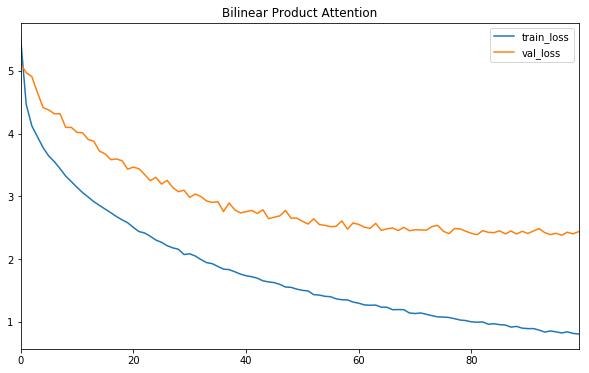

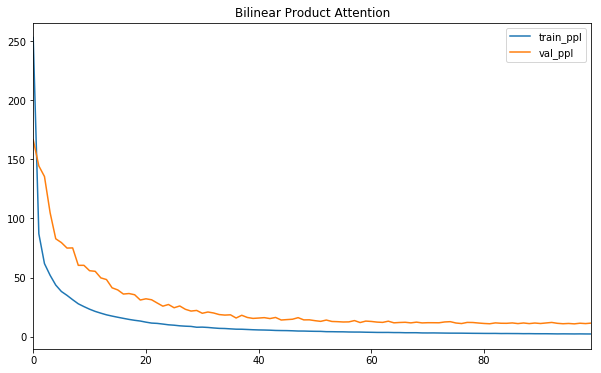

In [82]:
plot_metrics(bilinear_training_metrics, "Bilinear Product Attention", chart_filter='loss')
plot_metrics(bilinear_training_metrics, "Bilinear Product Attention", chart_filter='ppl')

In [83]:
import json

with open(os.path.join(SAVE_DIR, 'bilinear_model.json'), 'w') as fp:
    json.dump(bilinear_training_metrics, fp)

In [84]:
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'bilinear_model_bidirectional.pt')))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.298 | Test PPL:   9.954 |


input = you should try to see it .
output = tu devrais essayer de le voir . <eos>


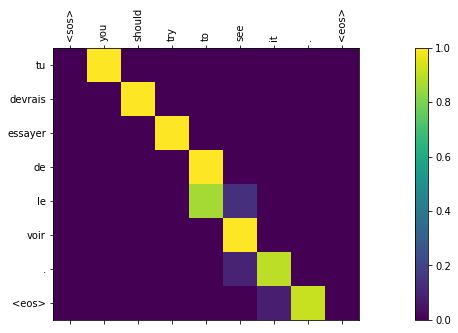

input = i m shorter than you .
output = je suis plus petit que vous . <eos>


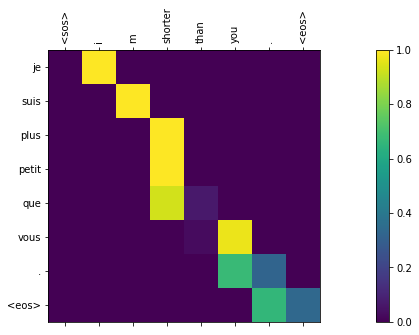

input = it was difficult for me .
output = c etait difficile difficile pour moi . <eos>


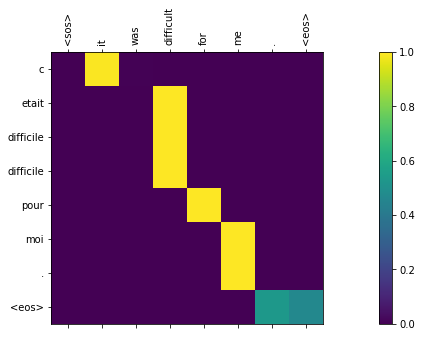

input = i don t follow .
output = je ne suis pas en train de <unk> . <eos>


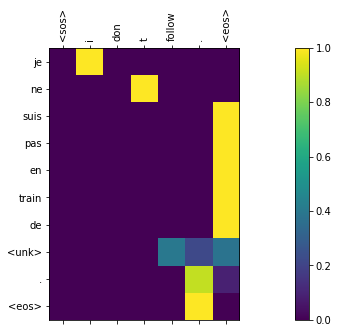

input = the region is relatively rich in mineral resources .
output = la porte va riche riche en <unk> . <eos>


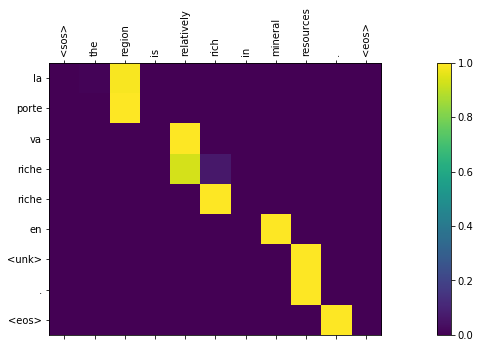

input = i took many photos and some of them were printed in black and white .
output = j ai pris beaucoup d entre dans l . <eos>


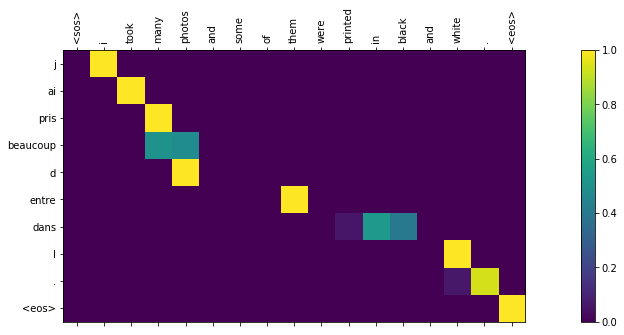

In [85]:
evaluateAndShowAttention(model, 'you should try to see it .')

evaluateAndShowAttention(model, 'i m shorter than you .')

evaluateAndShowAttention(model, 'it was difficult for me .')

evaluateAndShowAttention(model, 'i don t follow .')

evaluateAndShowAttention(model, 'the region is relatively rich in mineral resources .')

evaluateAndShowAttention(model, 'i took many photos and some of them were printed in black and white .')

### 2.2.7 Linear Attention

In [86]:
enc_bidirectional = True
enc_num_layers = 4

# attn = BilinearAttention(ENC_HID_DIM, DEC_HID_DIM) # Uni-directional attention
attn = LinearAttention((ENC_HID_DIM * 2), (ENC_HID_DIM * 2)) # Bi-directional attention

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, ENC_DROPOUT, 
              num_layers=enc_num_layers, bidirectional=enc_bidirectional)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, ENC_HID_DIM, DEC_HID_DIM, DEC_DROPOUT, 
              attn, bidirectional_input=enc_bidirectional)

model = Seq2Seq(enc, dec, device).to(device)

learning_rate = 0.01
decoder_learning_ratio = 5.0

# Initialize optimizers and criterion
# Initialize optimizers and criterion
encoder_optimizer = optim.SGD(enc.parameters(), lr=learning_rate, momentum=0.9)
decoder_optimizer = optim.SGD(dec.parameters(), lr=learning_rate * decoder_learning_ratio, momentum=0.9)
enc_scheduler = optim.lr_scheduler.ReduceLROnPlateau(encoder_optimizer, 'min', patience=5)
dec_scheduler = optim.lr_scheduler.ReduceLROnPlateau(decoder_optimizer, 'min', patience=5)

optimizer = MultipleOptimizer(encoder_optimizer, 
                        decoder_optimizer)

In [87]:
# Train
pad_idx = TRG.vocab.stoi['<pad>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)

# SAVE_DIR = 'models'
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'linear_model.pt')
linear_training_metrics = {}

best_valid_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
    os.makedirs(f'{SAVE_DIR}')

for epoch in range(N_EPOCHS):
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
    
    print(f'| Epoch: {epoch+1:03} | Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f} | Val. Loss: {valid_loss:.3f} | Val. PPL: {math.exp(valid_loss):7.3f} |')
    linear_training_metrics[epoch] = {'train_loss':train_loss, 'train_ppl':math.exp(train_loss), 'val_loss':valid_loss, 'val_ppl':math.exp(valid_loss)}

A Jupyter Widget


| Epoch: 001 | Train Loss: 5.667 | Train PPL: 289.199 | Val. Loss: 5.113 | Val. PPL: 166.197 |


A Jupyter Widget


| Epoch: 002 | Train Loss: 4.456 | Train PPL:  86.150 | Val. Loss: 5.046 | Val. PPL: 155.421 |


A Jupyter Widget


| Epoch: 003 | Train Loss: 4.250 | Train PPL:  70.085 | Val. Loss: 5.001 | Val. PPL: 148.508 |


A Jupyter Widget


| Epoch: 004 | Train Loss: 4.094 | Train PPL:  59.951 | Val. Loss: 4.780 | Val. PPL: 119.104 |


A Jupyter Widget


| Epoch: 005 | Train Loss: 3.943 | Train PPL:  51.585 | Val. Loss: 4.763 | Val. PPL: 117.052 |


A Jupyter Widget


| Epoch: 006 | Train Loss: 3.788 | Train PPL:  44.187 | Val. Loss: 4.685 | Val. PPL: 108.320 |


A Jupyter Widget


| Epoch: 007 | Train Loss: 3.688 | Train PPL:  39.980 | Val. Loss: 4.528 | Val. PPL:  92.607 |


A Jupyter Widget


| Epoch: 008 | Train Loss: 3.567 | Train PPL:  35.415 | Val. Loss: 4.516 | Val. PPL:  91.514 |


A Jupyter Widget


| Epoch: 009 | Train Loss: 3.509 | Train PPL:  33.430 | Val. Loss: 4.454 | Val. PPL:  85.994 |


A Jupyter Widget


| Epoch: 010 | Train Loss: 3.406 | Train PPL:  30.132 | Val. Loss: 4.328 | Val. PPL:  75.780 |


A Jupyter Widget


| Epoch: 011 | Train Loss: 3.341 | Train PPL:  28.240 | Val. Loss: 4.249 | Val. PPL:  70.030 |


A Jupyter Widget


| Epoch: 012 | Train Loss: 3.285 | Train PPL:  26.697 | Val. Loss: 4.232 | Val. PPL:  68.822 |


A Jupyter Widget


| Epoch: 013 | Train Loss: 3.194 | Train PPL:  24.386 | Val. Loss: 4.154 | Val. PPL:  63.701 |


A Jupyter Widget


| Epoch: 014 | Train Loss: 3.115 | Train PPL:  22.544 | Val. Loss: 4.072 | Val. PPL:  58.695 |


A Jupyter Widget


| Epoch: 015 | Train Loss: 3.086 | Train PPL:  21.890 | Val. Loss: 4.083 | Val. PPL:  59.339 |


A Jupyter Widget


| Epoch: 016 | Train Loss: 2.991 | Train PPL:  19.907 | Val. Loss: 4.033 | Val. PPL:  56.455 |


A Jupyter Widget


| Epoch: 017 | Train Loss: 2.954 | Train PPL:  19.177 | Val. Loss: 3.943 | Val. PPL:  51.588 |


A Jupyter Widget


| Epoch: 018 | Train Loss: 2.879 | Train PPL:  17.805 | Val. Loss: 3.916 | Val. PPL:  50.178 |


A Jupyter Widget


| Epoch: 019 | Train Loss: 2.824 | Train PPL:  16.848 | Val. Loss: 3.849 | Val. PPL:  46.949 |


A Jupyter Widget


| Epoch: 020 | Train Loss: 2.781 | Train PPL:  16.137 | Val. Loss: 3.865 | Val. PPL:  47.699 |


A Jupyter Widget


| Epoch: 021 | Train Loss: 2.736 | Train PPL:  15.431 | Val. Loss: 3.867 | Val. PPL:  47.785 |


A Jupyter Widget


| Epoch: 022 | Train Loss: 2.676 | Train PPL:  14.528 | Val. Loss: 3.824 | Val. PPL:  45.775 |


A Jupyter Widget


| Epoch: 023 | Train Loss: 2.632 | Train PPL:  13.901 | Val. Loss: 3.715 | Val. PPL:  41.054 |


A Jupyter Widget


| Epoch: 024 | Train Loss: 2.598 | Train PPL:  13.435 | Val. Loss: 3.696 | Val. PPL:  40.292 |


A Jupyter Widget


| Epoch: 025 | Train Loss: 2.558 | Train PPL:  12.904 | Val. Loss: 3.684 | Val. PPL:  39.805 |


A Jupyter Widget


| Epoch: 026 | Train Loss: 2.504 | Train PPL:  12.234 | Val. Loss: 3.673 | Val. PPL:  39.366 |


A Jupyter Widget


| Epoch: 027 | Train Loss: 2.473 | Train PPL:  11.862 | Val. Loss: 3.651 | Val. PPL:  38.530 |


A Jupyter Widget


| Epoch: 028 | Train Loss: 2.444 | Train PPL:  11.521 | Val. Loss: 3.535 | Val. PPL:  34.286 |


A Jupyter Widget


| Epoch: 029 | Train Loss: 2.369 | Train PPL:  10.690 | Val. Loss: 3.522 | Val. PPL:  33.848 |


A Jupyter Widget


| Epoch: 030 | Train Loss: 2.337 | Train PPL:  10.353 | Val. Loss: 3.446 | Val. PPL:  31.372 |


A Jupyter Widget


| Epoch: 031 | Train Loss: 2.317 | Train PPL:  10.149 | Val. Loss: 3.485 | Val. PPL:  32.627 |


A Jupyter Widget


| Epoch: 032 | Train Loss: 2.297 | Train PPL:   9.939 | Val. Loss: 3.438 | Val. PPL:  31.135 |


A Jupyter Widget


| Epoch: 033 | Train Loss: 2.255 | Train PPL:   9.537 | Val. Loss: 3.424 | Val. PPL:  30.679 |


A Jupyter Widget


| Epoch: 034 | Train Loss: 2.214 | Train PPL:   9.155 | Val. Loss: 3.485 | Val. PPL:  32.608 |


A Jupyter Widget


| Epoch: 035 | Train Loss: 2.186 | Train PPL:   8.897 | Val. Loss: 3.484 | Val. PPL:  32.599 |


A Jupyter Widget


| Epoch: 036 | Train Loss: 2.150 | Train PPL:   8.584 | Val. Loss: 3.279 | Val. PPL:  26.555 |


A Jupyter Widget


| Epoch: 037 | Train Loss: 2.102 | Train PPL:   8.185 | Val. Loss: 3.265 | Val. PPL:  26.168 |


A Jupyter Widget


| Epoch: 038 | Train Loss: 2.094 | Train PPL:   8.114 | Val. Loss: 3.231 | Val. PPL:  25.308 |


A Jupyter Widget


| Epoch: 039 | Train Loss: 2.044 | Train PPL:   7.722 | Val. Loss: 3.265 | Val. PPL:  26.191 |


A Jupyter Widget


| Epoch: 040 | Train Loss: 2.016 | Train PPL:   7.511 | Val. Loss: 3.300 | Val. PPL:  27.103 |


A Jupyter Widget


| Epoch: 041 | Train Loss: 2.008 | Train PPL:   7.448 | Val. Loss: 3.212 | Val. PPL:  24.831 |


A Jupyter Widget


| Epoch: 042 | Train Loss: 1.953 | Train PPL:   7.047 | Val. Loss: 3.194 | Val. PPL:  24.381 |


A Jupyter Widget


| Epoch: 043 | Train Loss: 1.935 | Train PPL:   6.926 | Val. Loss: 3.132 | Val. PPL:  22.911 |


A Jupyter Widget


| Epoch: 044 | Train Loss: 1.906 | Train PPL:   6.726 | Val. Loss: 3.153 | Val. PPL:  23.404 |


A Jupyter Widget


| Epoch: 045 | Train Loss: 1.857 | Train PPL:   6.402 | Val. Loss: 3.135 | Val. PPL:  22.987 |


A Jupyter Widget


| Epoch: 046 | Train Loss: 1.839 | Train PPL:   6.288 | Val. Loss: 3.192 | Val. PPL:  24.339 |


A Jupyter Widget


| Epoch: 047 | Train Loss: 1.826 | Train PPL:   6.212 | Val. Loss: 3.128 | Val. PPL:  22.834 |


A Jupyter Widget


| Epoch: 048 | Train Loss: 1.796 | Train PPL:   6.028 | Val. Loss: 3.048 | Val. PPL:  21.063 |


A Jupyter Widget


| Epoch: 049 | Train Loss: 1.754 | Train PPL:   5.775 | Val. Loss: 3.150 | Val. PPL:  23.325 |


A Jupyter Widget


| Epoch: 050 | Train Loss: 1.731 | Train PPL:   5.648 | Val. Loss: 3.049 | Val. PPL:  21.098 |


A Jupyter Widget


| Epoch: 051 | Train Loss: 1.712 | Train PPL:   5.539 | Val. Loss: 3.085 | Val. PPL:  21.862 |


A Jupyter Widget


| Epoch: 052 | Train Loss: 1.696 | Train PPL:   5.450 | Val. Loss: 2.973 | Val. PPL:  19.546 |


A Jupyter Widget


| Epoch: 053 | Train Loss: 1.694 | Train PPL:   5.443 | Val. Loss: 2.983 | Val. PPL:  19.747 |


A Jupyter Widget


| Epoch: 054 | Train Loss: 1.641 | Train PPL:   5.161 | Val. Loss: 2.989 | Val. PPL:  19.871 |


A Jupyter Widget


| Epoch: 055 | Train Loss: 1.631 | Train PPL:   5.110 | Val. Loss: 2.926 | Val. PPL:  18.658 |


A Jupyter Widget


| Epoch: 056 | Train Loss: 1.601 | Train PPL:   4.960 | Val. Loss: 2.994 | Val. PPL:  19.970 |


A Jupyter Widget


| Epoch: 057 | Train Loss: 1.588 | Train PPL:   4.896 | Val. Loss: 2.956 | Val. PPL:  19.215 |


A Jupyter Widget


| Epoch: 058 | Train Loss: 1.563 | Train PPL:   4.773 | Val. Loss: 2.962 | Val. PPL:  19.344 |


A Jupyter Widget


| Epoch: 059 | Train Loss: 1.519 | Train PPL:   4.569 | Val. Loss: 2.911 | Val. PPL:  18.378 |


A Jupyter Widget


| Epoch: 060 | Train Loss: 1.521 | Train PPL:   4.578 | Val. Loss: 2.914 | Val. PPL:  18.429 |


A Jupyter Widget


| Epoch: 061 | Train Loss: 1.476 | Train PPL:   4.376 | Val. Loss: 2.977 | Val. PPL:  19.625 |


A Jupyter Widget


| Epoch: 062 | Train Loss: 1.481 | Train PPL:   4.396 | Val. Loss: 2.925 | Val. PPL:  18.636 |


A Jupyter Widget


| Epoch: 063 | Train Loss: 1.463 | Train PPL:   4.319 | Val. Loss: 2.882 | Val. PPL:  17.849 |


A Jupyter Widget


| Epoch: 064 | Train Loss: 1.409 | Train PPL:   4.091 | Val. Loss: 2.929 | Val. PPL:  18.702 |


A Jupyter Widget


| Epoch: 065 | Train Loss: 1.431 | Train PPL:   4.183 | Val. Loss: 2.886 | Val. PPL:  17.930 |


A Jupyter Widget


| Epoch: 066 | Train Loss: 1.375 | Train PPL:   3.956 | Val. Loss: 2.966 | Val. PPL:  19.421 |


A Jupyter Widget


| Epoch: 067 | Train Loss: 1.371 | Train PPL:   3.938 | Val. Loss: 2.878 | Val. PPL:  17.777 |


A Jupyter Widget


| Epoch: 068 | Train Loss: 1.348 | Train PPL:   3.851 | Val. Loss: 2.859 | Val. PPL:  17.451 |


A Jupyter Widget


| Epoch: 069 | Train Loss: 1.313 | Train PPL:   3.716 | Val. Loss: 2.903 | Val. PPL:  18.229 |


A Jupyter Widget


| Epoch: 070 | Train Loss: 1.308 | Train PPL:   3.697 | Val. Loss: 2.860 | Val. PPL:  17.458 |


A Jupyter Widget


| Epoch: 071 | Train Loss: 1.285 | Train PPL:   3.613 | Val. Loss: 2.851 | Val. PPL:  17.313 |


A Jupyter Widget


| Epoch: 072 | Train Loss: 1.268 | Train PPL:   3.554 | Val. Loss: 2.875 | Val. PPL:  17.729 |


A Jupyter Widget


| Epoch: 073 | Train Loss: 1.259 | Train PPL:   3.521 | Val. Loss: 2.842 | Val. PPL:  17.156 |


A Jupyter Widget


| Epoch: 074 | Train Loss: 1.239 | Train PPL:   3.453 | Val. Loss: 2.898 | Val. PPL:  18.131 |


A Jupyter Widget


| Epoch: 075 | Train Loss: 1.205 | Train PPL:   3.337 | Val. Loss: 2.885 | Val. PPL:  17.902 |


A Jupyter Widget


| Epoch: 076 | Train Loss: 1.220 | Train PPL:   3.388 | Val. Loss: 2.910 | Val. PPL:  18.362 |


A Jupyter Widget


| Epoch: 077 | Train Loss: 1.195 | Train PPL:   3.303 | Val. Loss: 2.842 | Val. PPL:  17.153 |


A Jupyter Widget


| Epoch: 078 | Train Loss: 1.181 | Train PPL:   3.256 | Val. Loss: 2.889 | Val. PPL:  17.974 |


A Jupyter Widget


| Epoch: 079 | Train Loss: 1.142 | Train PPL:   3.134 | Val. Loss: 2.842 | Val. PPL:  17.143 |


A Jupyter Widget


| Epoch: 080 | Train Loss: 1.135 | Train PPL:   3.112 | Val. Loss: 2.876 | Val. PPL:  17.751 |


A Jupyter Widget


| Epoch: 081 | Train Loss: 1.126 | Train PPL:   3.083 | Val. Loss: 2.869 | Val. PPL:  17.611 |


A Jupyter Widget


| Epoch: 082 | Train Loss: 1.101 | Train PPL:   3.007 | Val. Loss: 2.839 | Val. PPL:  17.104 |


A Jupyter Widget


| Epoch: 083 | Train Loss: 1.094 | Train PPL:   2.987 | Val. Loss: 2.809 | Val. PPL:  16.590 |


A Jupyter Widget


| Epoch: 084 | Train Loss: 1.089 | Train PPL:   2.972 | Val. Loss: 2.809 | Val. PPL:  16.590 |


A Jupyter Widget


| Epoch: 085 | Train Loss: 1.078 | Train PPL:   2.940 | Val. Loss: 2.834 | Val. PPL:  17.005 |


A Jupyter Widget


| Epoch: 086 | Train Loss: 1.033 | Train PPL:   2.808 | Val. Loss: 2.824 | Val. PPL:  16.841 |


A Jupyter Widget


| Epoch: 087 | Train Loss: 1.040 | Train PPL:   2.828 | Val. Loss: 2.877 | Val. PPL:  17.763 |


A Jupyter Widget


| Epoch: 088 | Train Loss: 1.010 | Train PPL:   2.745 | Val. Loss: 2.756 | Val. PPL:  15.742 |


A Jupyter Widget


| Epoch: 089 | Train Loss: 0.997 | Train PPL:   2.711 | Val. Loss: 2.790 | Val. PPL:  16.285 |


A Jupyter Widget


| Epoch: 090 | Train Loss: 0.999 | Train PPL:   2.715 | Val. Loss: 2.797 | Val. PPL:  16.401 |


A Jupyter Widget


| Epoch: 091 | Train Loss: 0.991 | Train PPL:   2.695 | Val. Loss: 2.807 | Val. PPL:  16.566 |


A Jupyter Widget


| Epoch: 092 | Train Loss: 0.964 | Train PPL:   2.623 | Val. Loss: 2.819 | Val. PPL:  16.760 |


A Jupyter Widget


| Epoch: 093 | Train Loss: 0.953 | Train PPL:   2.592 | Val. Loss: 2.819 | Val. PPL:  16.759 |


A Jupyter Widget


| Epoch: 094 | Train Loss: 0.944 | Train PPL:   2.569 | Val. Loss: 2.818 | Val. PPL:  16.745 |


A Jupyter Widget


| Epoch: 095 | Train Loss: 0.927 | Train PPL:   2.526 | Val. Loss: 2.778 | Val. PPL:  16.095 |


A Jupyter Widget


| Epoch: 096 | Train Loss: 0.933 | Train PPL:   2.542 | Val. Loss: 2.769 | Val. PPL:  15.936 |


A Jupyter Widget


| Epoch: 097 | Train Loss: 0.889 | Train PPL:   2.432 | Val. Loss: 2.855 | Val. PPL:  17.381 |


A Jupyter Widget


| Epoch: 098 | Train Loss: 0.895 | Train PPL:   2.447 | Val. Loss: 2.834 | Val. PPL:  17.019 |


A Jupyter Widget


| Epoch: 099 | Train Loss: 0.867 | Train PPL:   2.379 | Val. Loss: 2.888 | Val. PPL:  17.963 |


A Jupyter Widget


| Epoch: 100 | Train Loss: 0.880 | Train PPL:   2.411 | Val. Loss: 2.910 | Val. PPL:  18.350 |


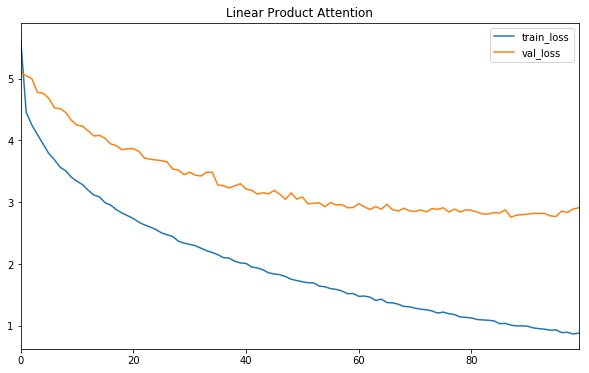

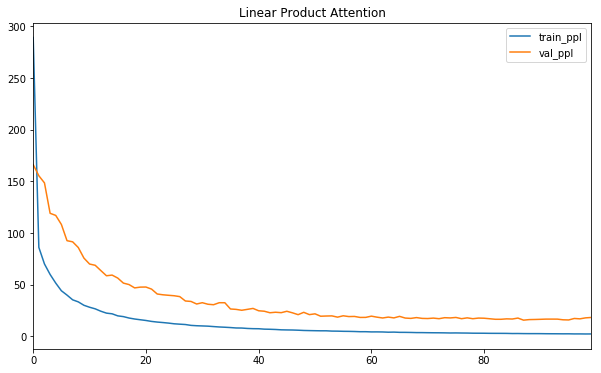

In [88]:
plot_metrics(linear_training_metrics, "Linear Product Attention", chart_filter='loss')
plot_metrics(linear_training_metrics, "Linear Product Attention", chart_filter='ppl')

In [89]:
model.load_state_dict(torch.load(os.path.join(SAVE_DIR, 'linear_model.pt')))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 2.670 | Test PPL:  14.442 |


In [90]:
import json

with open(os.path.join(SAVE_DIR, 'linear_model.json'), 'w') as fp:
    json.dump(linear_training_metrics, fp)

input = you should try to see it .
output = tu devrais essayer de le voir . <eos>


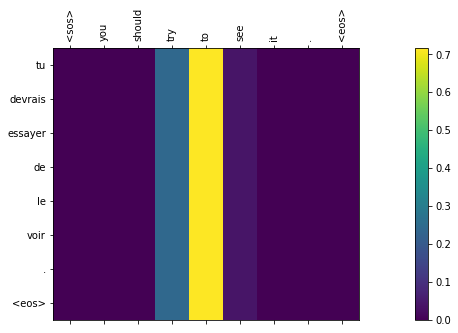

input = i m shorter than you .
output = je suis plus petit que vous . <eos>


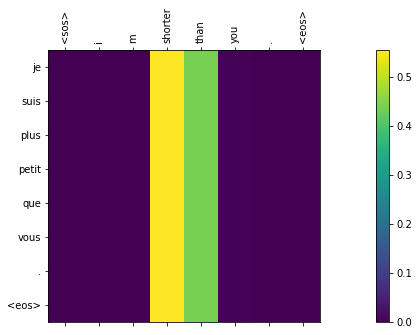

input = it was difficult for me .
output = c etait difficile pour pour moi . <eos>


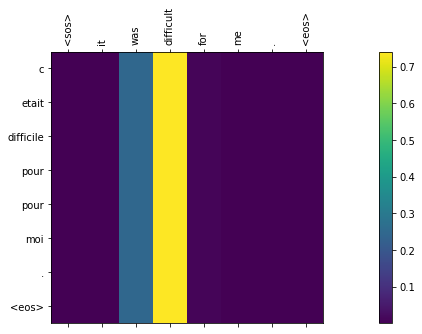

input = i don t follow .
output = je n ai pas l air si d . . <eos>


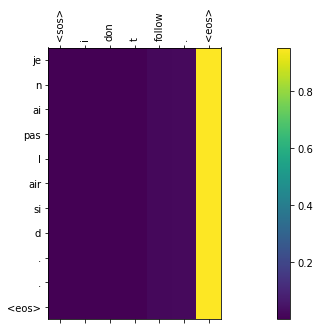

input = the region is relatively rich in mineral resources .
output = le <unk> est est riche en deux . . <eos>


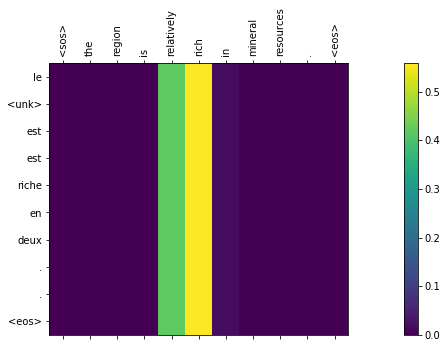

input = i took many photos and some of them were printed in black and white .
output = je sortis de et et en en . . <eos>


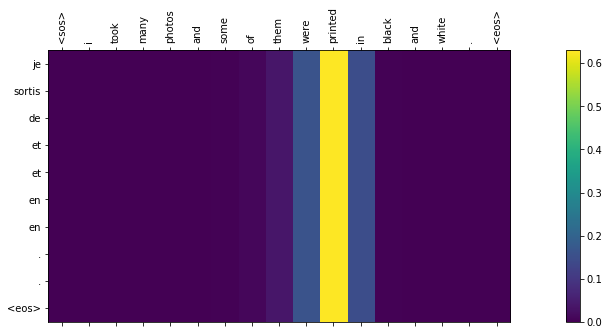

In [91]:
evaluateAndShowAttention(model, 'you should try to see it .')

evaluateAndShowAttention(model, 'i m shorter than you .')

evaluateAndShowAttention(model, 'it was difficult for me .')

evaluateAndShowAttention(model, 'i don t follow .')

evaluateAndShowAttention(model, 'the region is relatively rich in mineral resources .')

evaluateAndShowAttention(model, 'i took many photos and some of them were printed in black and white .')

# 3. Comparison of Methods

In [92]:
def mergedicts(dict1, dict2):
    for k in set(dict1.keys()).union(dict2.keys()):
        if k in dict1 and k in dict2:
            if isinstance(dict1[k], dict) and isinstance(dict2[k], dict):
                yield (k, dict(mergedicts(dict1[k], dict2[k])))
            else:
                # If one of the values is not a dict, you can't continue merging it.
                # Value from second dict overrides one in first and we move on.
                yield (k, dict2[k])
                # Alternatively, replace this with exception raiser to alert you of value conflicts
        elif k in dict1:
            yield (k, dict1[k])
        else:
            yield (k, dict2[k])

In [96]:
all_results = {}
with open('./exp_small_data_100/bahdanau_model.json') as f:
    data = json.load(f)
    for e, l in data.items():
        new_data = {}
        for k,v in l.items():
            new_data["bahdanau_" + k] = v
        data[e] = new_data
    all_results = dict(mergedicts(all_results, data))

with open('./exp_small_data_100/dot_model.json') as f:
    data = json.load(f)
    for e, l in data.items():
        new_data = {}
        for k,v in l.items():
            new_data["dot_" + k] = v
        data[e] = new_data
    all_results = dict(mergedicts(all_results, data))

with open('./exp_small_data_100/cosine_model.json') as f:
    data = json.load(f)
    for e, l in data.items():
        new_data = {}
        for k,v in l.items():
            new_data["cosine_" + k] = v
        data[e] = new_data
    all_results = dict(mergedicts(all_results, data))

with open('./exp_small_data_100/bilinear_model.json') as f:
    data = json.load(f)
    for e, l in data.items():
        new_data = {}
        for k,v in l.items():
            new_data["bilinear_" + k] = v
        data[e] = new_data
    all_results = dict(mergedicts(all_results, data))

with open('./exp_small_data_100/linear_model.json') as f:
    data = json.load(f)
    for e, l in data.items():
        new_data = {}
        for k,v in l.items():
            new_data["linear_" + k] = v
        data[e] = new_data
    all_results = dict(mergedicts(all_results, data))

# Ensure keys are sorted as integers instead of strings
all_results = {int(k):v for k,v in all_results.items()}

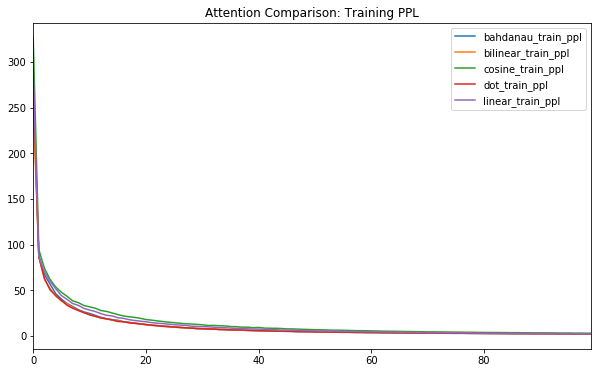

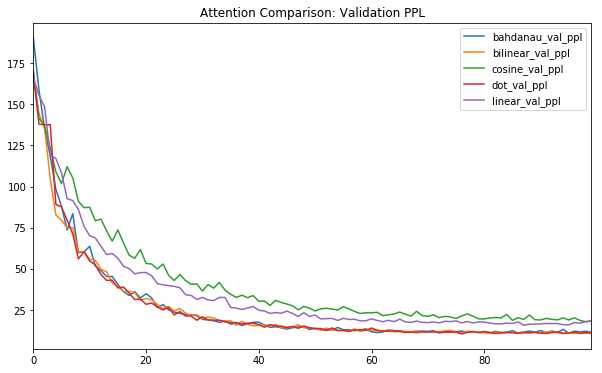

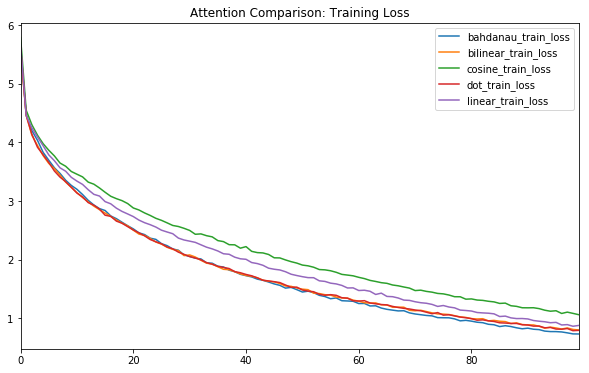

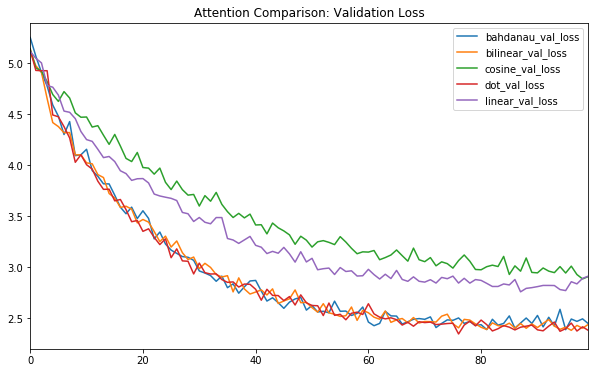

In [97]:
plot_metrics(all_results, "Attention Comparison: Training PPL", 
             'train_ppl')
plot_metrics(all_results, "Attention Comparison: Validation PPL", 
             'val_ppl')

plot_metrics(all_results, "Attention Comparison: Training Loss", 
             'train_loss')
plot_metrics(all_results, "Attention Comparison: Validation Loss", 
             'val_loss')

In [33]:
from torchnlp.metrics import get_moses_multi_bleu

hypotheses = ["The brown fox jumps over the dog 笑"]
references = ["The quick brown fox jumps over the lazy dog 笑"]

# Compute BLEU score with the official BLEU perl script
get_moses_multi_bleu(hypotheses, references, lowercase=True)


47.88